# 09 Trophoblast trajectory analysis

Here we want to analyse the motif changes along trophoblast differentiation into syncytotrophoblast. first we subset all the cells beloning to the trophoblast/amnion, then we refine our annotation by rerunning dimensionality reduction and clustering, followed by manually looking at the GeneScore and Motif markers for each cluster. The cells along the 'trophoblast -> cytotrophoblast -> syncytotrophoblast progenitor -> syncytotrophoblast' trajectory are then used for pseudotime analysis.

In [1]:
here::i_am("01_create_arrow.R")
source(here::here("settings.R"))
source(here::here("load_archr.R"))
library(viridis)

addArchRThreads(30)

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/code

Setting default number of Parallel threads to 1.

Setting addArchRVerbose = FALSE

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==

#### Subset Trophoblast/Amnion celltypes

From celltype annotation we know that the Trophoblast/amnion celltypes belong to 'Clusters_PeakMatrix' C1 - C5. These also include a few erythroid cells, which will be removed after the final round of annotation.

In [1]:
meta = data.frame(ArchRProject@cellColData)

ERROR: Error in data.frame(ArchRProject@cellColData): object 'ArchRProject' not found


In [ ]:
#keep_celltypes = c('Trophoblast', 'CYT', 'SCT')
clusters = paste0('C', 1:5)

In [ ]:
keep_cells = meta[meta$Clusters_PeakMatrix %in% clusters, 'cell']

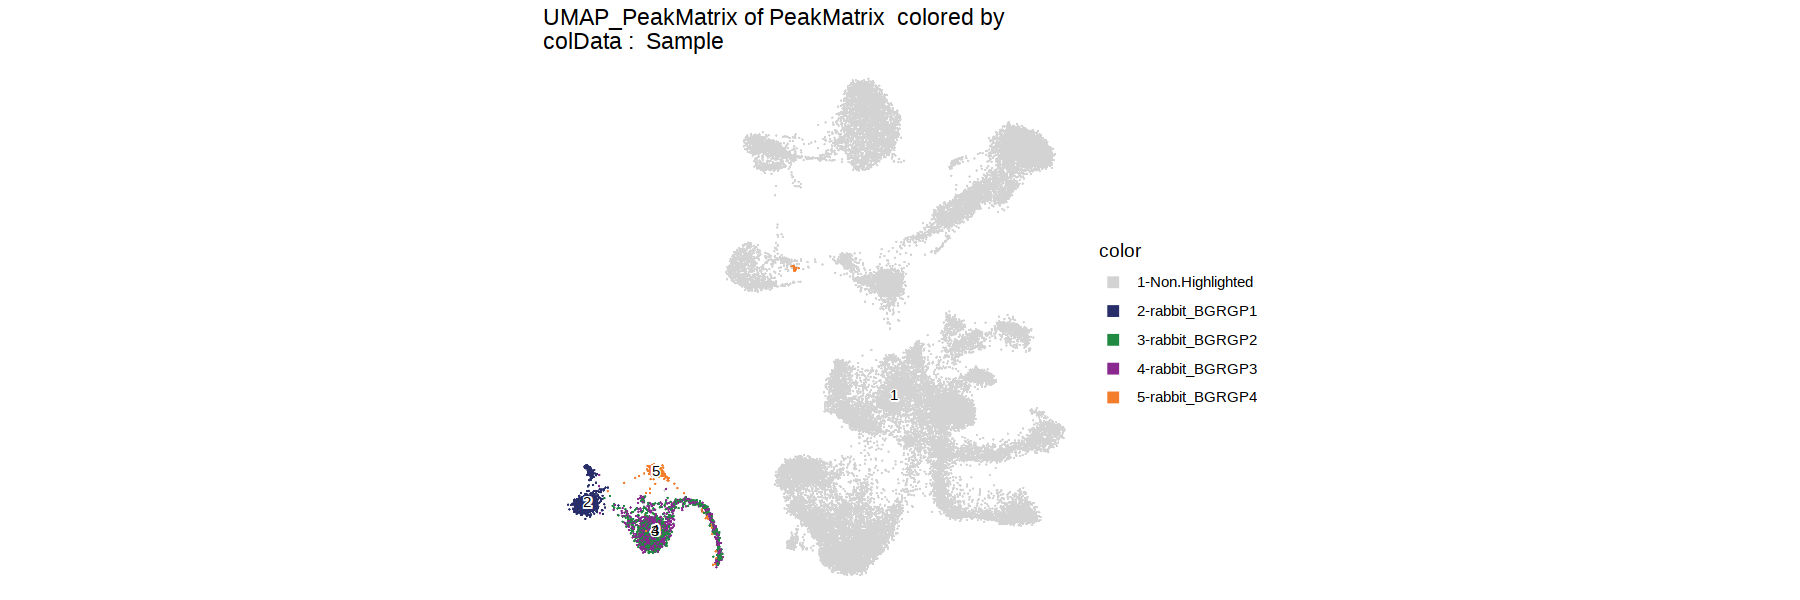

In [13]:
plotEmbedding(
  ArchRProj = ArchRProject,
  embedding = "UMAP_PeakMatrix",
  highlightCells = keep_cells) + theme_void()

In [15]:
# This subsets our selected cells into a new ArchR project. This may take a while.
ArchRProject = subsetArchRProject(
  ArchRProj = ArchRProject,
  cells = keep_cells,
  outputDirectory = "Trophoblast",
  dropCells = TRUE,
  logFile = NULL,
  threads = getArchRThreads(),
  force = TRUE
)

Dropping ImputeWeights Since You Are Subsetting Cells! ImputeWeights is a cell-x-cell Matrix!

Copying ArchRProject to new outputDirectory : /rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Trophoblast

Copying Arrow Files...

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 9): Annotations

Copying Other Files (2 of 9): Background-Peaks.rds

Copying Other Files (3 of 9): GroupCoverages

Copying Other Files (4 of 9): IterativeLSI

Copying Other Files (5 of 9): PeakCalls

Copying Other Files (6 of 9): PeakMatrix

Copying Other Files (7 of 9): Plots

Copying Other Files (8 of 9): RNAIntegration

Copying Other Files (9 of 9): TileMatrix

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\          

#### Load Trophoblast trajectory

In [1]:
source(here::here("settings.R"))
ArchRProject <- loadArchRProject(file.path(io$basedir, 'ArchR/Trophoblast'))
library(viridis)

# I/O
io$plot.trophoblast = file.path(io$basedir, 'ArchR/Trophoblast/Plots')
dir.create(io$plot.trophoblast, showWarnings = FALSE)

Setting default number of Parallel threads to 1.

Setting addArchRVerbose = FALSE

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\__

In [2]:
# redefine the dimensionality reduction function for trophoblast cells
dim_redu = function(project = ArchRProject, matrix='PeakMatrix', ndims=20, nfeatures=25000, n_neighbors=25,min_dist=0.7 ){
    seed = 42

    # Options
    opts = list()
    opts$lsi.iterations = 2
    opts$lsi.cluster.resolution = 0.5

    ###########################
    ## Latent Semantic Index ##
    ###########################

    # Iterative LSI: two iterations
    project <- addIterativeLSI(
      ArchRProj = project,
      useMatrix = matrix, 
      name = paste0(matrix, '_tropho'), 
      dimsToUse = 1:ndims,
      firstSelection = "Top",
      depthCol = "nFrags",
      iterations = opts$lsi.iterations, 
      saveIterations = FALSE,
      varFeatures = nfeatures, 
      force = TRUE,
      seed = seed
    )

    #Add clusters
    project <- addClusters(input = project,  
                             reducedDims = paste0(matrix, '_tropho'),
                             resolution = opts$lsi.cluster.resolution, 
                             force=TRUE)

    project <- addUMAP(
      ArchRProj = project, 
      reducedDims = paste0(matrix, '_tropho'),
      name = paste0("UMAP_tropho_", matrix),
      metric = "cosine",
      nNeighbors = n_neighbors, 
      minDist = min_dist, 
      seed = seed,
      saveModel = FALSE,
      force = TRUE)

    p =  plotEmbedding(project, 
        embedding=paste0("UMAP_tropho_", matrix),
        colorBy = "cellColData", 
        name = "celltype_v1")+ theme_void() + theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))
    print(p)
        return(project)
}

In [3]:
addArchRThreads(30)

Setting default number of Parallel threads to 30.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2761
Number of edges: 121727

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8747
Number of communities: 9
Elapsed time: 0 seconds


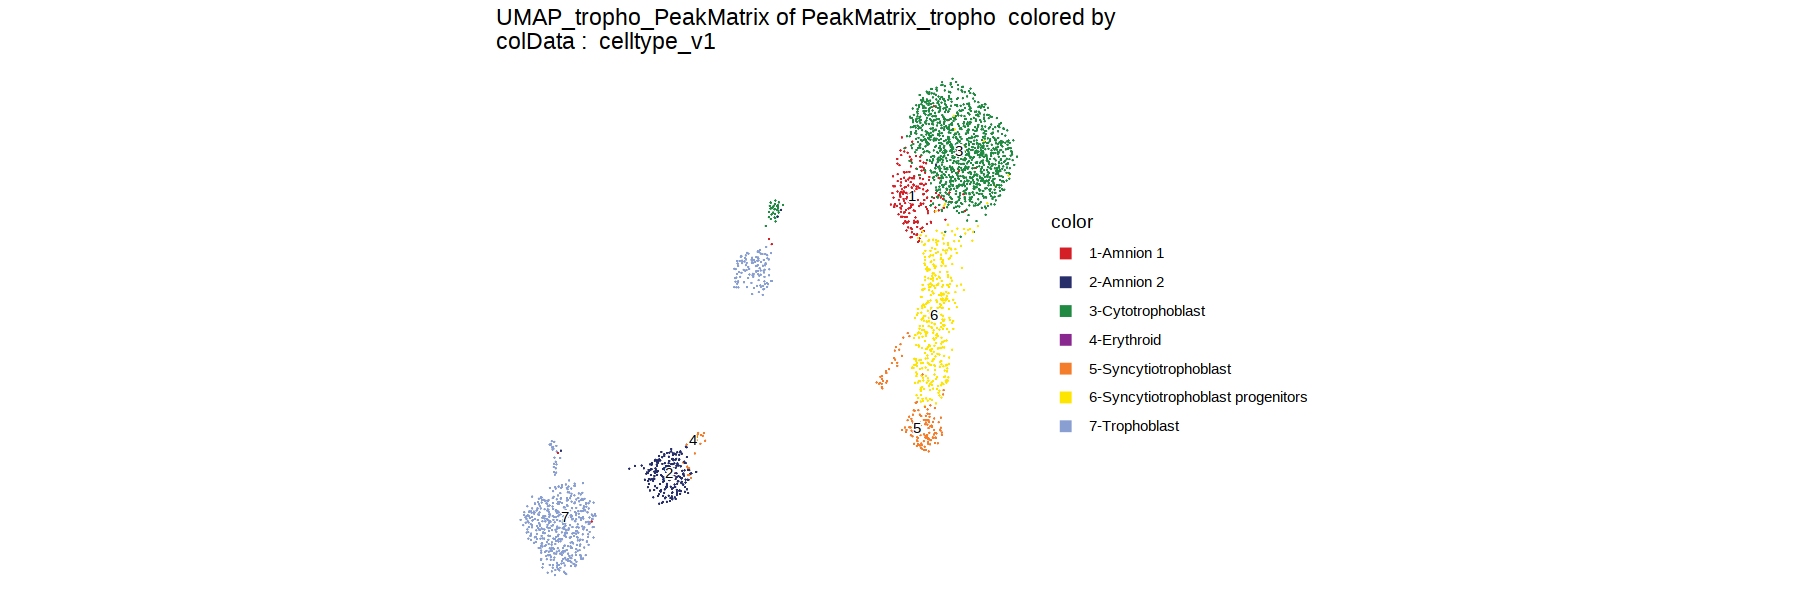

In [25]:
# Rerun dimensionality reduction on subsetted data
ArchRProject = suppressMessages(dim_redu(ndims=25, nfeatures=55000))

$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

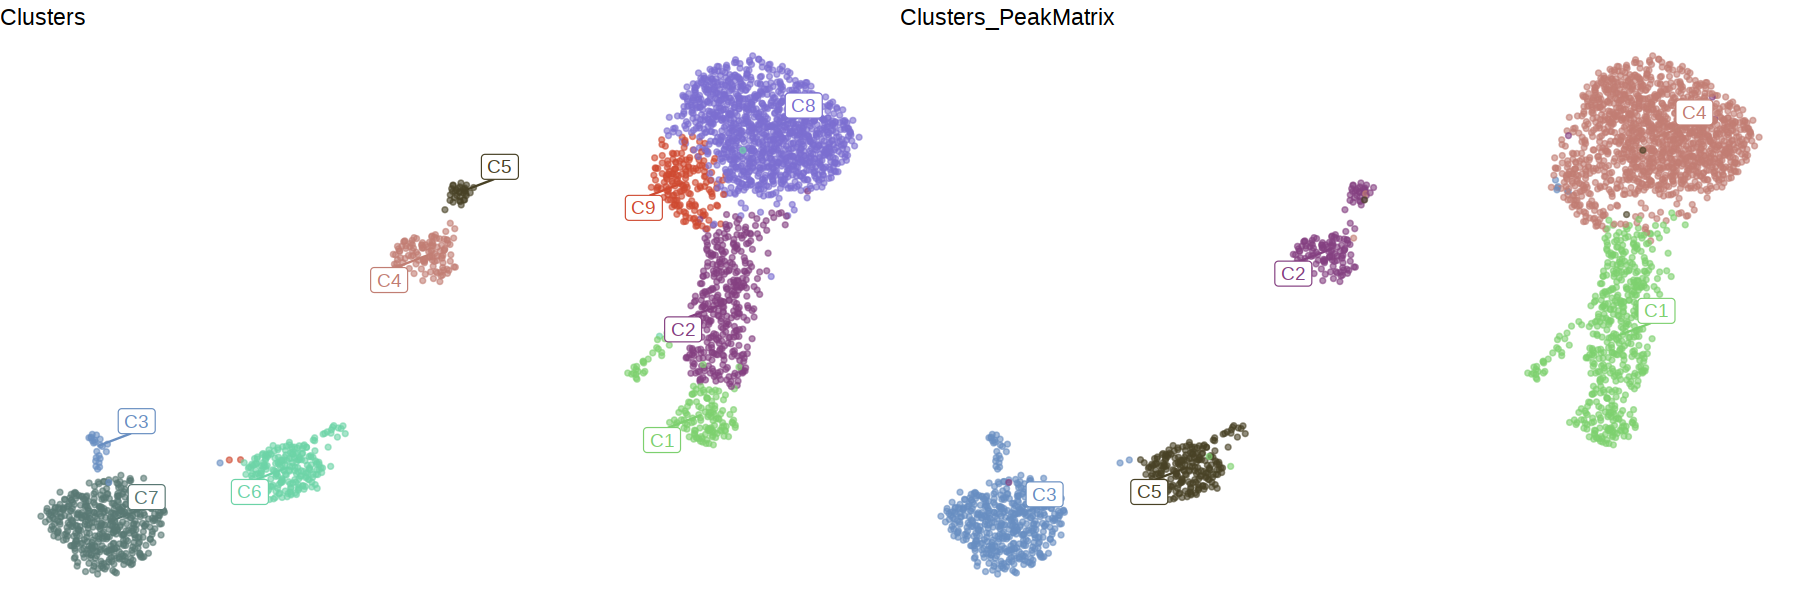

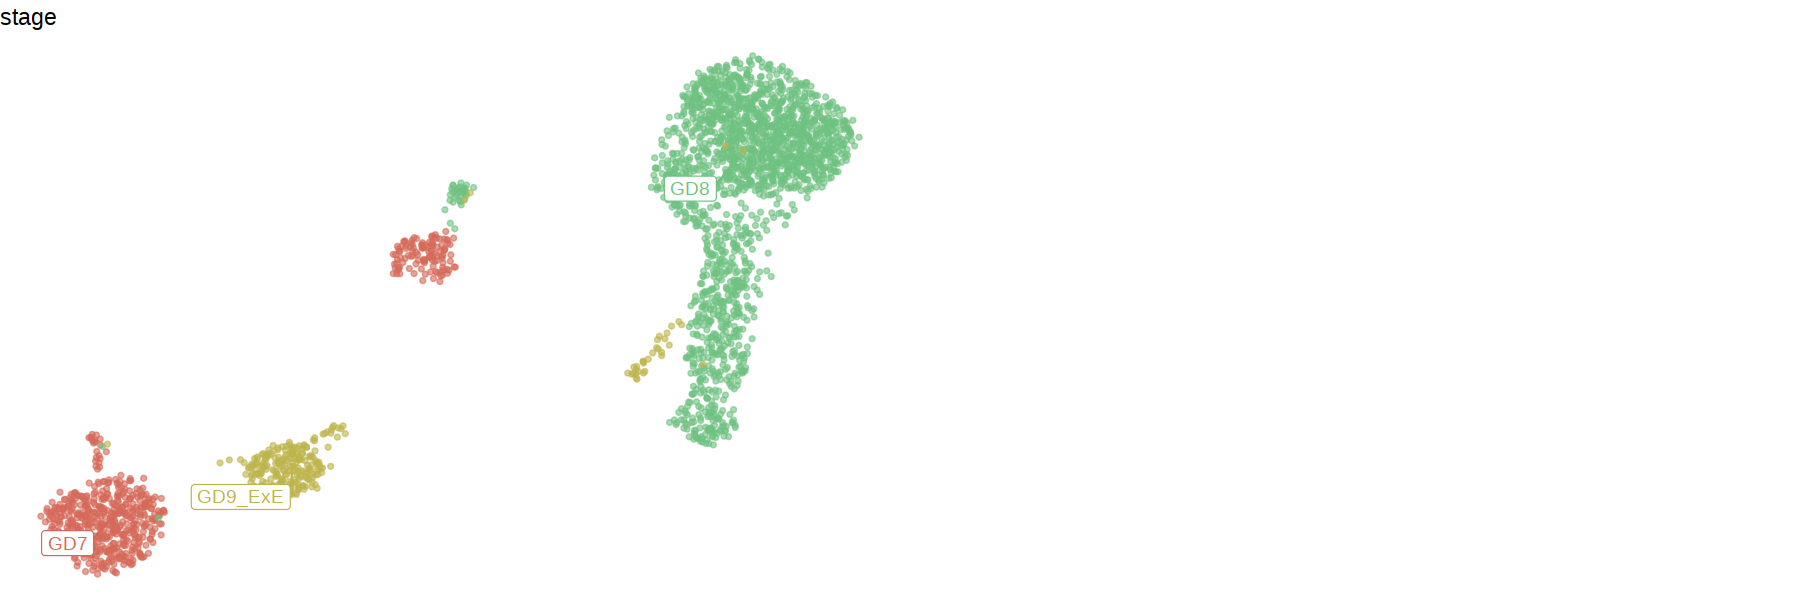

In [4]:
# Fetch UMAP coordinates
umap.dt <- getEmbedding(ArchRProject,paste0("UMAP_tropho_PeakMatrix")) %>%
  round(2) %>%
  as.data.table(keep.rownames = T) %>%
  setnames(c("cell","umap1","umap2"))

# Plot
sample_metadata = as.data.frame(getCellColData(ArchRProject))
to.plot <- umap.dt %>%
  merge(sample_metadata,by="cell")

plot = function(colors){
    # Get labels at centre of group
    labels = to.plot[,list(median(umap1), median(umap2)), 
                                  by=colors] %>%
        setnames(c('V1', 'V2'), c('umap1', 'umap2'))
    
    # Plot
    plot = ggplot(to.plot, aes_string(x="umap1", y="umap2", color=colors)) +
        geom_point(size=1, alpha=0.6) + 
        ggrepel::geom_label_repel(data=labels, 
                                    aes_string('umap1', 'umap2', label=colors, color=colors), 
                                    max.overlaps=Inf,
                                    box.padding = 0.8) + # adds text labels
        ggtitle(colors) +
        theme_void() + 
        theme(legend.position='none')
    # Add colors to umap
    if(colors=='stage'){
        plot = plot + scale_color_manual(values=opts$stage.colors)
    } else{
        plot = plot + scale_color_manual(values = as.vector(c(ArchRPalettes[[3]],ArchRPalettes[[5]], ArchRPalettes[[8]],ArchRPalettes[[9]]))[1:length(unique(to.plot[[colors]]))]) 
    }
    return(plot)
}

ggarrange(plot('Clusters'), 
          plot('Clusters_PeakMatrix'), 
          plot('stage'), 
          ncol=2)

In [7]:
# Save plots
pdf(sprintf("%s/ATAC_supp_UMAP_trophoblast.pdf",io$sup_figures), width=4, height=3)
    plot('stage')
    plot('Clusters')
dev.off()

png 
  2

#### Rerun RNA integration with only relevant celltypes

In [27]:
# Load RNA & select only relevant celltypes
io$RNA_in <- file.path(io$basedir,"RNA/RangedSummarizedExperiment.rds")
sceRNA = readRDS(io$RNA_in)

In [31]:
# Subset RNA
keep = c('Trophoblast',
         'Cytotrophoblast',
         'Syncytiotrophoblast progenitors',
         'Syncytiotrophoblast',
         'Amnion 1', 
         'Amnion 2', 
         'Amnion 3')
sceRNA = sceRNA[,sceRNA@colData$celltype %in% keep]

In [32]:
# matrix to use for integration
matrix = 'PeakMatrix_tropho'

# Add imputation 
ArchRProject <- addImputeWeights(ArchRProject, 
                                reducedDims = matrix)

addArchRThreads(1)

# Integrate
## Note that this time the RNA integration is not done per stage anymore.
ArchRProject <- addGeneIntegrationMatrix(
    ArchRProj = ArchRProject, 
    useMatrix = "GeneScoreMatrix",
    matrixName = paste0("GeneIntegrationMatrix_", matrix),
    reducedDims =  matrix,
    seRNA = sceRNA,
    addToArrow = TRUE,
    force= TRUE,
    groupRNA = "celltype",
    nameCell = paste0("predictedCell_Trohpo", matrix),
    nameGroup = paste0("celltype_Tropho", matrix),
    nameScore = paste0("score_Tropho", matrix))

Warning message in sprintf("Completed Getting Magic Weights!", round(object.size(weightList)/10^9, :
“one argument not used by format 'Completed Getting Magic Weights!'”
Setting default number of Parallel threads to 1.

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Filtering 5 dims correlated > 0.75 to log10(depth + 1)

Warning message in sprintf("Completed Getting Magic Weights!", round(object.size(weightList)/10^9, :
“one argument not used by format 'Completed Getting Magic Weights!'”
Getting ImputeWeights

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”
Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, pass

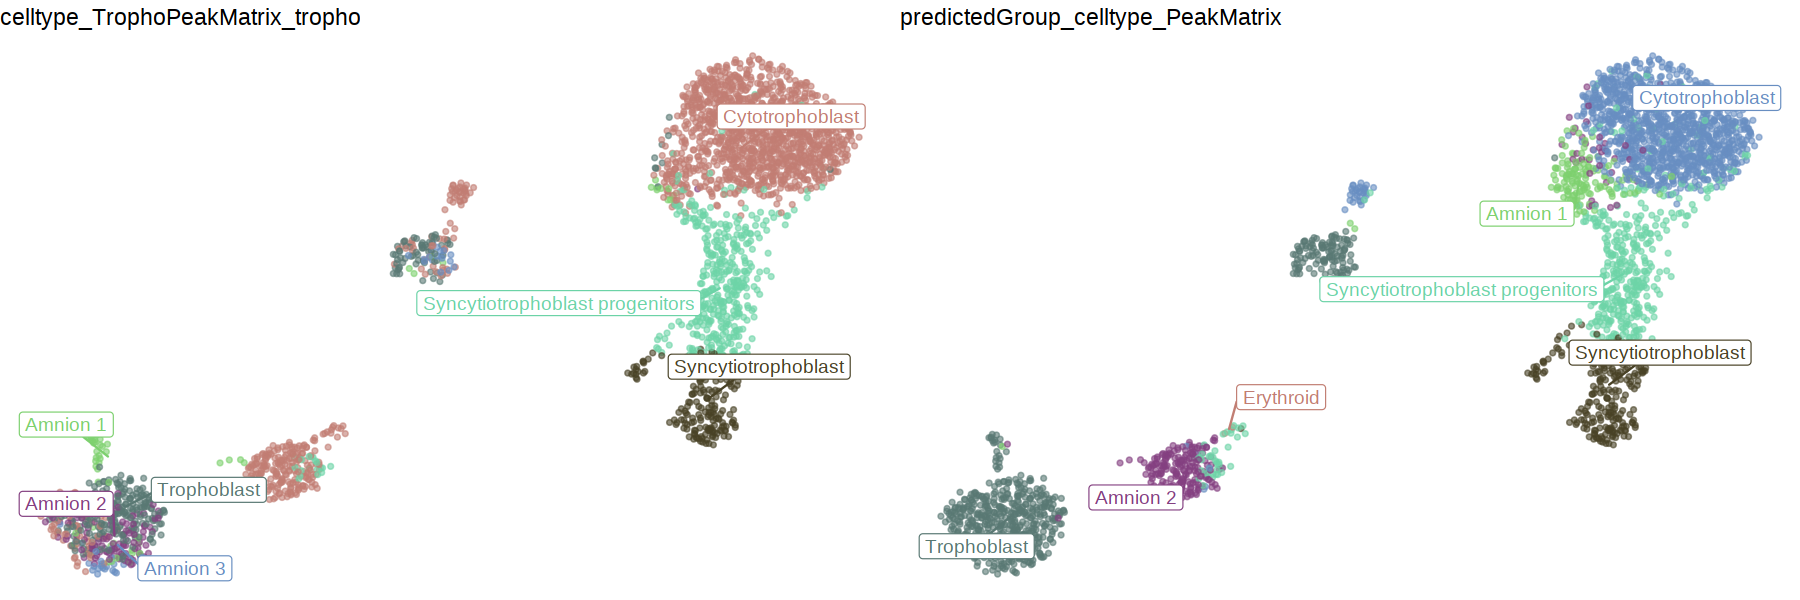

In [36]:
# Fetch UMAP coordinates
umap.dt <- getEmbedding(ArchRProject,paste0("UMAP_tropho_PeakMatrix")) %>%
  round(2) %>%
  as.data.table(keep.rownames = T) %>%
  setnames(c("cell","umap1","umap2"))

# Plot
sample_metadata = as.data.frame(getCellColData(ArchRProject))
to.plot <- umap.dt %>%
  merge(sample_metadata,by="cell")

plot = function(colors){
    # Get labels at centre of group
    labels = to.plot[,list(median(umap1), median(umap2)), 
                                  by=colors] %>%
        setnames(c('V1', 'V2'), c('umap1', 'umap2'))
    
    # Plot
    plot = ggplot(to.plot, aes_string(x="umap1", y="umap2", color=colors)) +
        geom_point(size=1, alpha=0.6) + 
        ggrepel::geom_label_repel(data=labels, 
                                    aes_string('umap1', 'umap2', label=colors, color=colors), 
                                    max.overlaps=Inf,
                                    box.padding = 0.8) + # adds text labels
        ggtitle(colors) +
        theme_void() + 
        theme(legend.position='none')
    # Add colors to umap
    if(colors=='stage'){
        plot = plot + scale_color_manual(values=opts$stage.colors)
    } else{
        plot = plot + scale_color_manual(values = as.vector(c(ArchRPalettes[[3]],ArchRPalettes[[5]], ArchRPalettes[[8]],ArchRPalettes[[9]]))[1:length(unique(to.plot[[colors]]))]) 
    }
    return(plot)
}

ggarrange(plot('celltype_TrophoPeakMatrix_tropho'), 
          plot('predictedGroup_celltype_PeakMatrix'), ncol=2)

Rerunning integration does not seem to work well, instead continue with manual annotation of clusters based on GeneScores and Motif accessibility and label transfer of whole atlas

In [37]:
saveArchRProject(ArchRProj = ArchRProject)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

class: ArchRProject 
outputDirectory: /rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Trophoblast 
samples(4): rabbit_BGRGP1 rabbit_BGRGP3 rabbit_BGRGP2 rabbit_BGRGP4
sampleColData names(1): ArrowFiles
cellColData names(29): Sample TSSEnrichment ...
  celltype_TrophoPeakMatrix_tropho score_TrophoPeakMatrix_tropho
numberOfCells(1): 2761
medianTSS(1): 3.371
medianFrags(1): 37340

### Plot markers per cluster

In [43]:
plot_volcano = function(celltype, n=25, FDR_thr=0.01, LogFC_thr = 1.25){
    
    ct_markers = markers[,colnames(markers)== celltype]
    ct_markers = ct_markers[order(-abs(ct_markers@assays@data$Log2FC))]

    to.plot = data.table(x = ct_markers@assays@data$Log2FC, y = ct_markers@assays@data$FDR, name=rowData(ct_markers)$name) %>%
        setnames(c('x.x', 'y.x'), c('LogFC', 'FDR')) %>% 
        .[,name:= gsub('ENSOCUG000000', 'ID_', name)] %>%
        .[,Diff:=ifelse(LogFC>=LogFC_thr & FDR<=FDR_thr, 'Up', ifelse(LogFC<=-LogFC_thr & FDR<=FDR_thr, 'Down', 'non'))]

     ggplot(to.plot[abs(LogFC)>0,], aes(LogFC, -log10(FDR), col=Diff)) + 
        geom_point() + 
        scale_color_manual(values=c('Down' = 'blue', 'non' = 'gray70', 'Up' = 'red'), name='Significant') + 
        geom_hline(yintercept = -log10(FDR_thr), linetype = 'dashed', color = 'gray30') +
        geom_vline(xintercept = c(-LogFC_thr, LogFC_thr), linetype = 'dashed', color = 'gray30') +
        geom_vline(xintercept = 0, linetype = 'dashed', color = 'black') +
        ggtitle(celltype,
               sprintf('Down: %d, Up: %d', nrow(to.plot[Diff=='Down', ]), nrow(to.plot[Diff=='Up', ]))) + 
        ggrepel::geom_label_repel(data=to.plot[Diff=='Down',][!grep('ID_', name),] %>% top_n(n, -LogFC), 
                                    aes(LogFC, -log10(FDR), label=name),
                                    max.overlaps=Inf,
                                    box.padding = 0.3) + 
        ggrepel::geom_label_repel(data=to.plot[Diff=='Up',][!grep('ID_', name),] %>% top_n(n, LogFC), 
                                    aes(LogFC, -log10(FDR), label=name),
                                    max.overlaps=Inf,
                                    box.padding = 0.3) +
        theme_bw() + 
        theme(text=element_text(size=15, color='black'), 
              legend.position='none')

}

In [46]:
getAvailableMatrices(ArchRProject)

[1] "GeneIntegrationMatrix_PeakMatrix"       
[2] "GeneIntegrationMatrix_PeakMatrix_tropho"
[3] "GeneScoreMatrix"                        
[4] "MotifMatrix"                            
[5] "PeakMatrix"                             
[6] "TileMatrix"

In [57]:
group_by= 'Clusters'
matrix = 'GeneScoreMatrix'

markers <- getMarkerFeatures(
    ArchRProj = ArchRProject, 
    useMatrix = matrix, 
    groupBy = group_by,
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon", verbose=TRUE)

saveRDS(markers, file.path(io$plot.trophoblast, sprintf('markers_%s.rds', matrix)))

groups = unique(ArchRProject@cellColData[[group_by]])

pdf(file.path(io$plot.trophoblast, 'volcano_GeneScoreMatrix.pdf'), width=10, height=9)
    lapply(groups, plot_volcano)
dev.off()

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]


png 
  2

In [47]:
group_by= 'Clusters'
matrix = 'GeneIntegrationMatrix_PeakMatrix'

markers <- getMarkerFeatures(
    ArchRProj = ArchRProject, 
    useMatrix = matrix, 
    groupBy = group_by,
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon", verbose=TRUE)

saveRDS(markers, file.path(io$plot.trophoblast, sprintf('markers_%s.rds', matrix)))

groups = unique(ArchRProject@cellColData[[group_by]])

pdf(file.path(io$plot.trophoblast, 'volcano_GeneIntegrationMatrix.pdf'), width=10, height=9)
    lapply(groups, plot_volcano)
dev.off()

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]


png 
  2

In [49]:
group_by= 'Clusters'
matrix = 'MotifMatrix'

markers <- getMarkerFeatures(
    ArchRProj = ArchRProject, 
    useMatrix = matrix, 
    groupBy = group_by,
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon", verbose=TRUE)

rowData(markers)$name = sapply(strsplit(rowData(markers)$name, '_'), '[', 1)

groups = unique(ArchRProject@cellColData[[group_by]])

pdf(file.path(io$plot.trophoblast, 'volcano_MotifMatrix.pdf'), width=10, height=9)
    lapply(groups, plot_volcano)
dev.off()

2022-04-29 14:03:07 : SuppressedMessaged due to getArchRVerbose() is FALSE!



#### Plot known markers

In [4]:
meta = as.data.table(ArchRProject@cellColData[,c('cell', 'Clusters')])

In [5]:
markers = fread(file.path(io$basedir,'Tropho_amnion_markers.csv'), header=F) %>% setnames(c('celltype', 'marker'))

In [6]:
head(markers)

celltype marker
1 Amnion 1 AQP2  
2 Amnion 1 AQP3  
3 Amnion 1 VTCN1 
4 Amnion 1 PGF   
5 Amnion 1 HPGD  
6 Amnion 1 TAC4

In [8]:
# Identify markers that span multiple celltypes
markers = rbindlist(lapply(unique(markers$marker), function(gene){
        tmp = markers[marker==gene]
        markers_ct = data.table(celltype=paste(tmp$celltype, collapse='/'), marker=gene)
        return(markers_ct)
    }))

In [9]:

plot_matrix = function(matrix){
    if(matrix!='MotifMatrix'){
        genescores = getMatrixFromProject(
          ArchRProj = ArchRProject,
          useMatrix = matrix)
        names = rowData(genescores)$name
        genescores = assays(genescores)[[matrix]]
        rownames(genescores) = names

        markers_matrix = genescores[rownames(genescores) %in% markers$marker,]
    }else{
        # Get gene score matrix
        Motif = getMatrixFromProject(
          ArchRProj = ArchRProject,
          useMatrix = "MotifMatrix")

        # Rename columns & rows
        gene_names = sapply(strsplit(Motif@elementMetadata$name,"_"), `[`, 1)
        Motif = Motif@assays@data$z
        rownames(Motif) = gene_names

        markers_matrix = Motif[rownames(Motif) %in% markers$marker,]
    }
    
    markers_matrix = imputeMatrix(mat = as.matrix(markers_matrix), 
                                 imputeWeights = getImputeWeights(ArchRProject))

    plot = as.data.table(t(markers_matrix), keep.rownames=T) %>% 
        setnames('rn', 'cell') %>%
        melt(id.vars =  'cell') %>%
        merge(meta, by='cell') %>%
        .[,value:=mean(value), by=c('variable', 'Clusters')] %>%
        unique(by=c('variable', 'value', 'Clusters')) %>% 
        .[,zscore:=scale(value), by=variable] %>%
        .[,maxmin:=value/max(value), by=variable]

    plot = merge(plot, markers%>% unique(by='marker'), by.x='variable', by.y='marker')

    p1 = ggplot(plot, aes(Clusters, factor(variable, levels=unique(markers$marker)), fill=zscore)) + 
        geom_tile() + 
        facet_grid(rows=vars(celltype), scales ='free_y', space = "free") + 
        ylab('markers') +
        ggtitle(matrix) + 
        scale_fill_gradient2(low='blue', mid='white', high='red') + 
        theme_classic() + theme(text = element_text(size = 15, colour='black'), 
                                axis.text.y = element_text(hjust=1, size = 10, colour='black'),
                                axis.text.x = element_text(size = 15, colour='black'),
                                axis.line.x = element_blank(),
                               strip.text.y = element_text(angle = 0, size=10))
    return(p1)
}

In [32]:
options(repr.plot.width=15, repr.plot.height=6)

Getting ImputeWeights

Getting ImputeWeights

Getting ImputeWeights



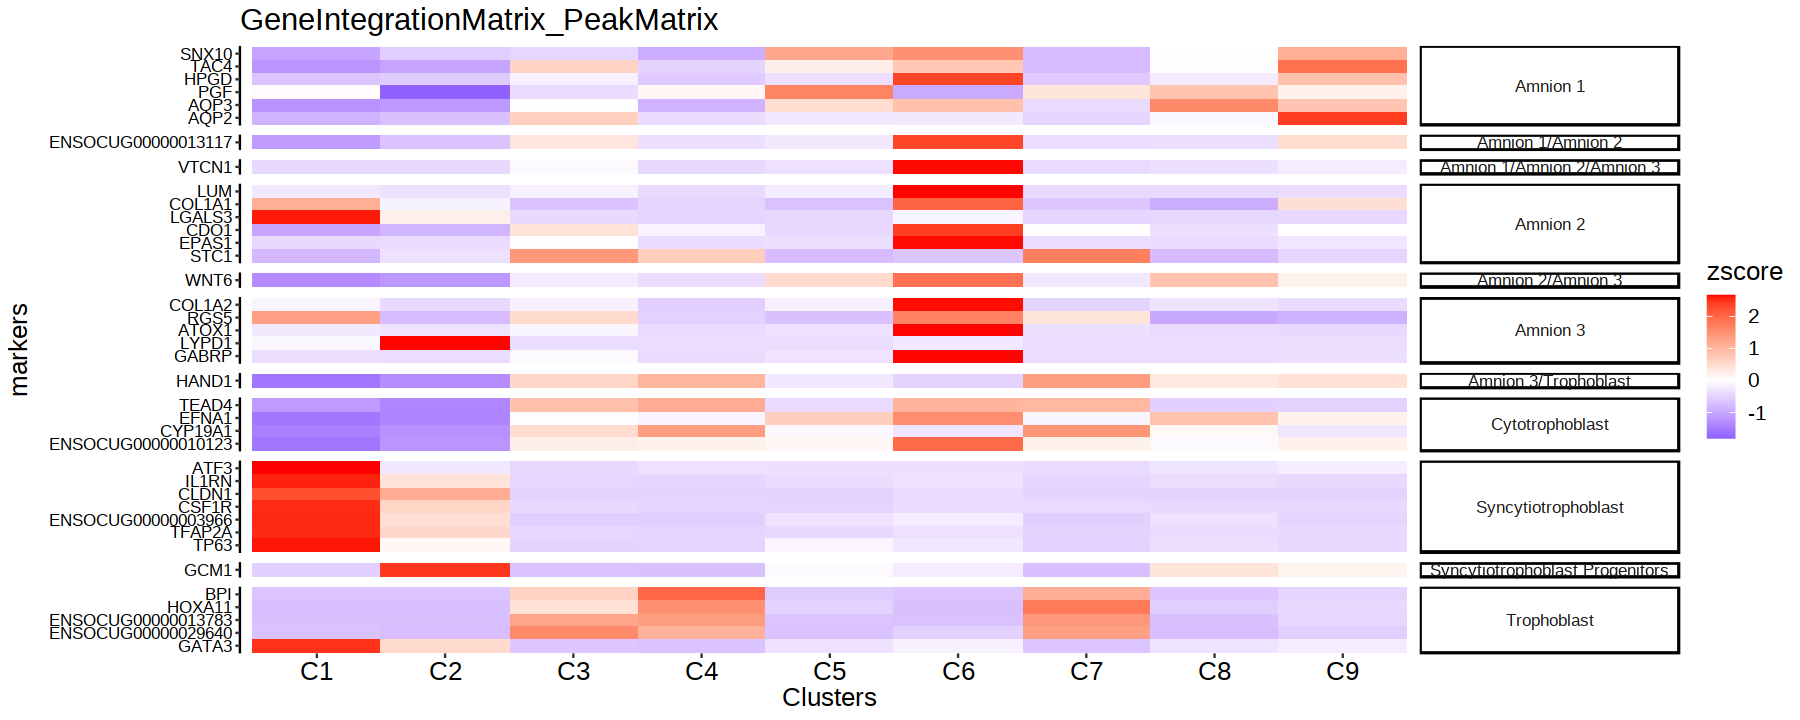

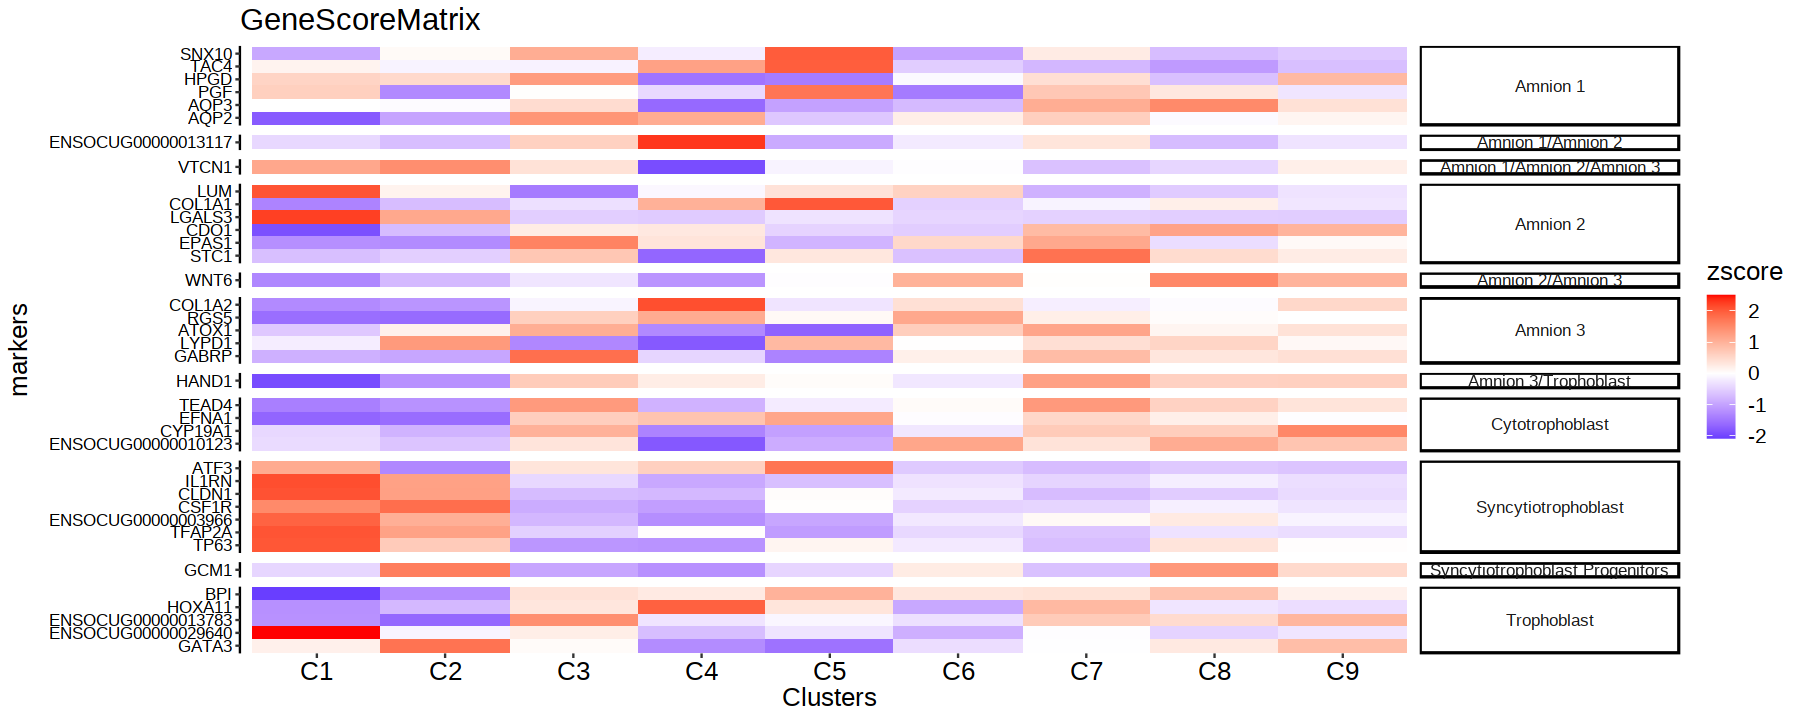

png 
  2

png 
  2

png 
  2

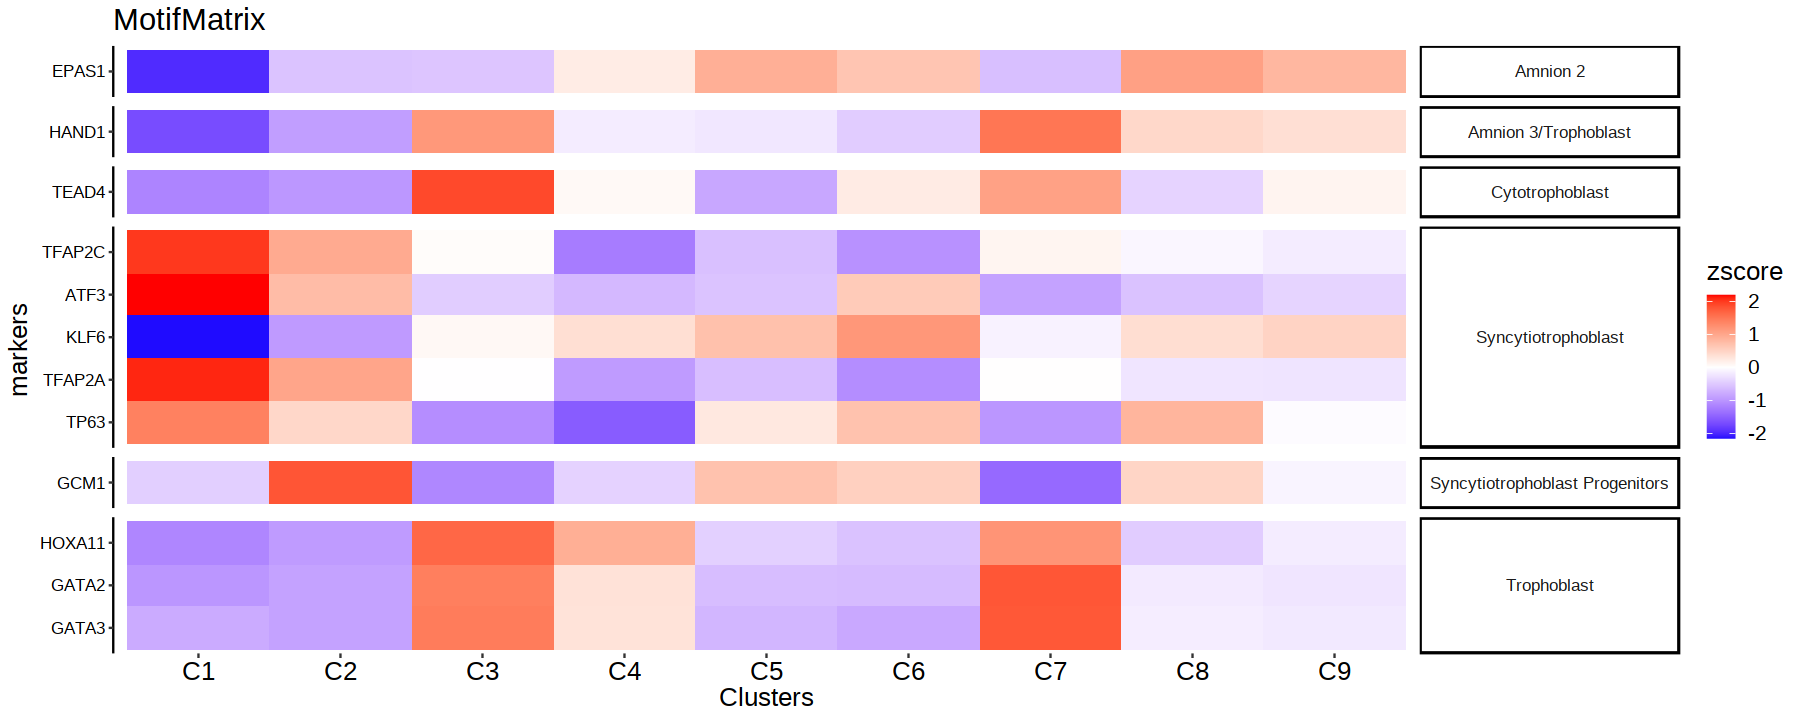

In [48]:
p1 = plot_matrix('GeneIntegrationMatrix_PeakMatrix')
p2 = plot_matrix('GeneScoreMatrix')
p3 = plot_matrix('MotifMatrix')

p1
p2
p3

pdf(file.path(io$plot.trophoblast, 'marker_genes_heatmap_integration.pdf'), width=8, height=8)
    p1
dev.off()

pdf(file.path(io$plot.trophoblast, 'marker_genes_heatmap_score.pdf'), width=8, height=8)
    p2
dev.off()

pdf(file.path(io$plot.trophoblast, 'marker_genes_heatmap_motif.pdf'), width=8, height=8)
    p3
dev.off()

In [49]:
## plot markers on UMAP
# Fetch UMAP coordinates
umap.dt <- getEmbedding(ArchRProject,paste0("UMAP_tropho_PeakMatrix")) %>%
  round(2) %>%
  as.data.table(keep.rownames = T) %>%
  setnames(c("cell","umap1","umap2"))

# Plot
sample_metadata = as.data.frame(getCellColData(ArchRProject))
to.plot <- umap.dt %>%
  merge(sample_metadata,by="cell") %>% .[,c('cell', 'umap1', 'umap2')]

In [59]:
keep = markers[marker %in% rownames(genescores)]$marker
keep

[1] "AQP2"               "AQP3"               "VTCN1"             
 [4] "PGF"                "HPGD"               "TAC4"              
 [7] "SNX10"              "ENSOCUG00000013117" "STC1"              
[10] "WNT6"               "EPAS1"              "CDO1"              
[13] "LGALS3"             "COL1A1"             "LUM"               
[16] "GABRP"              "LYPD1"              "HAND1"             
[19] "ATOX1"              "RGS5"               "COL1A2"            
[22] "GATA3"              "ENSOCUG00000029640" "ENSOCUG00000013783"
[25] "HOXA11"             "BPI"                "ENSOCUG00000010123"
[28] "CYP19A1"            "EFNA1"              "TEAD4"             
[31] "GCM1"               "TP63"               "TFAP2A"            
[34] "ENSOCUG00000003966" "CSF1R"              "CLDN1"             
[37] "IL1RN"              "ATF3"

In [61]:
addArchRThreads(1)
# #gene score
matrix = 'GeneScoreMatrix'
genescores = getMatrixFromProject(
  ArchRProj = ArchRProject,
  useMatrix = matrix)
names = rowData(genescores)$name
genescores = assays(genescores)[[matrix]]
rownames(genescores) = names
keep = markers[marker %in% rownames(genescores)]$marker
imputed_genescore = imputeMatrix(mat = as.matrix(genescores[row.names(genescores) %in% keep,]), 
                                     imputeWeights = getImputeWeights(ArchRProject))

# #gene integration
matrix = 'GeneIntegrationMatrix_PeakMatrix'
genescores = getMatrixFromProject(
  ArchRProj = ArchRProject,
  useMatrix = matrix)
names = rowData(genescores)$name
genescores = assays(genescores)[[matrix]]
rownames(genescores) = names
keep = markers[marker %in% rownames(genescores)]$marker
imputed_geneintegration = imputeMatrix(mat = as.matrix(genescores[row.names(genescores) %in% keep,]), 
                                     imputeWeights = getImputeWeights(ArchRProject))

# Motif Matrix
Motif = getMatrixFromProject(
  ArchRProj = ArchRProject,
  useMatrix = "MotifMatrix")
gene_names = sapply(strsplit(Motif@elementMetadata$name,"_"), `[`, 1)
Motif = Motif@assays@data$z
rownames(Motif) = gene_names
keep = markers[marker %in% rownames(Motif)]$marker
imputed_motif = imputeMatrix(mat = as.matrix(Motif[row.names(Motif) %in% keep,]), 
                                     imputeWeights = getImputeWeights(ArchRProject))

Setting default number of Parallel threads to 1.

Getting ImputeWeights

Getting ImputeWeights

Getting ImputeWeights



In [65]:
library(patchwork)
to.plot = to.plot[order(match(colnames(imputed_motif), cell)),]

plot_gene = function(gene){
    gene_score = data.frame(cell=colnames(imputed_genescore), gene_score = imputed_genescore[gene,])
    gene_int = data.frame(cell=colnames(imputed_geneintegration), gene_int = imputed_geneintegration[gene,])
    if(gene %in% rownames(imputed_motif)){
        motif = data.frame(cell=colnames(imputed_motif), motif = imputed_motif[gene,])
    }else{motif = data.frame(cell=colnames(imputed_motif))}
    
    to.plot_genes = to.plot %>% 
        merge(gene_score, by='cell') %>% 
        merge(gene_int, by='cell') %>% 
        merge(motif, by='cell')
    
    p = ggplot(to.plot_genes, aes(umap1, umap2)) + 
        scale_color_viridis(name='') + 
        theme_void() + theme(text=element_text(size=15), panel.border=element_rect(fill=NA))
    p1 = p + geom_point(aes(col=gene_score)) + ggtitle(paste0(gene, ' - ', markers[marker==gene]$celltype),
                                                      'Gene Score')
    p2 = p + geom_point(aes(col=gene_int)) + ggtitle('',
                                                      'Gene Integration')
    if(gene %in% rownames(imputed_motif)){
            p3 = p + geom_point(aes(col=motif)) + ggtitle('',
                                                      'Motif')
    }else{p3 = ggplot() + theme_void()}   

    
    #plot = grid.arrange(p1,p2,p3, ncol=2)
    plot = (p1 + p2) / (p3 + ggplot() + theme_void() )
}

In [68]:
genes = unique(markers$marker)[unique(markers$marker) %in% rownames(imputed_genescore)]
pdf(file.path(io$plot.trophoblast, 'marker_genes_umap.pdf'), width=8, height=8)
    lapply(genes, plot_gene)
dev.off()

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]

[[12]]

[[13]]

[[14]]

[[15]]

[[16]]

[[17]]

[[18]]

[[19]]

[[20]]

[[21]]

[[22]]

[[23]]

[[24]]

[[25]]

[[26]]

[[27]]

[[28]]

[[29]]

[[30]]

[[31]]

[[32]]

[[33]]

[[34]]

[[35]]

[[36]]

[[37]]

[[38]]


png 
  2

#### Annotate clusters based on marker expression and celltype annotation

https://docs.google.com/spreadsheets/d/1-nMnH8_2x3MaxPYU9OQUiVp3oxIRTUS764uALj5yWUA/edit#gid=0

In [10]:
unique(markers$celltype)

[1] "Amnion 1"                        "Amnion 1/Amnion 2/Amnion 3"     
 [3] "Amnion 1/Amnion 2"               "Amnion 2"                       
 [5] "Amnion 2/Amnion 3"               "Amnion 3"                       
 [7] "Amnion 3/Trophoblast"            "Trophoblast"                    
 [9] "Cytotrophoblast"                 "Syncytiotrophoblast Progenitors"
[11] "Syncytiotrophoblast"

#### Annotation and isolation of trophoblast --> syncytiotrophoblast lineage

In [4]:
plot_umap = function(colors){
    # Get labels at centre of group
    labels = to.plot[,list(median(umap1), median(umap2)), 
                                  by=colors] %>%
        setnames(c('V1', 'V2'), c('umap1', 'umap2'))
    
    # Plot
    plot = ggplot(to.plot, aes_string(x="umap1", y="umap2", color=colors)) +
        geom_point(size=1, alpha=0.6) + 
        ggrepel::geom_label_repel(data=labels, 
                                    aes_string('umap1', 'umap2', label=colors, color=colors), 
                                    max.overlaps=Inf,
                                    box.padding = 0.8, 
                                    fontface = "bold") + # adds text labels
        theme_void() + 
        theme(legend.position='none')
    return(plot)
}

In [5]:
annotation = data.table(Clusters = paste0('C', 1:9),
                       Tropho_celltype = c('Syncytiotrophoblast', #1
                                           'Syncytiotrophoblast Progenitors', #2
                                           'Trophoblast', #3
                                           'Amnion', #4
                                           'Amnion', #5 # Tac4, SNX10, PGF
                                           'Amnion', #6 
                                           'Trophoblast', #7
                                           'Cytotrophoblast', #8
                                           'Cytotrophoblast' #9 label transfer = amnion 2, but is very similar to cytotropho
                                          ))

annotation = annotation %>% .[match(ArchRProject@cellColData$Clusters, annotation$Clusters),]
ArchRProject@cellColData$celltype_tropho = annotation$Tropho_celltype

trajectory <- c('Trophoblast', 
                'Cytotrophoblast', 
                'Syncytiotrophoblast Progenitors',
                'Syncytiotrophoblast'
                )

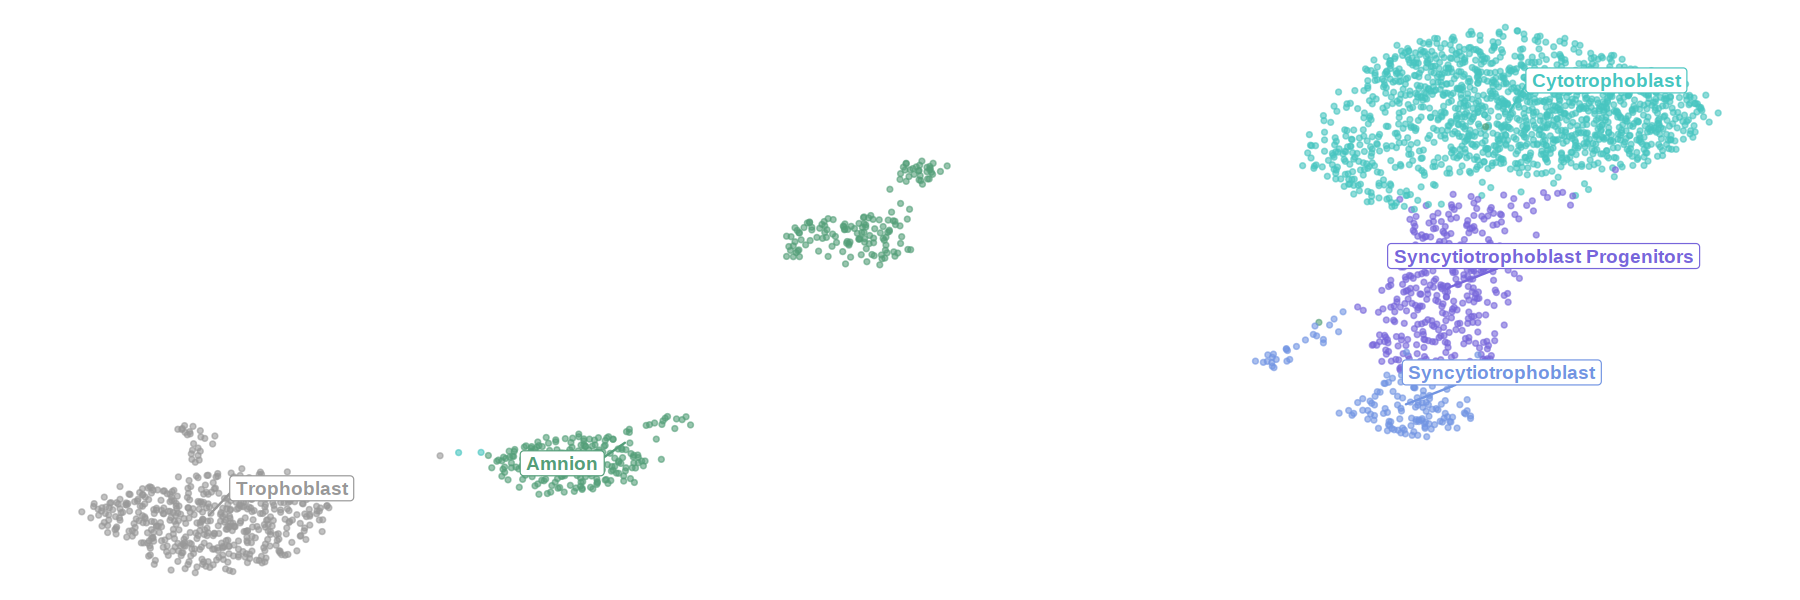

In [6]:
# Fetch UMAP coordinates
umap.dt <- getEmbedding(ArchRProject,paste0("UMAP_tropho_PeakMatrix")) %>%
  round(2) %>%
  as.data.table(keep.rownames = T) %>%
  setnames(c("cell","umap1","umap2"))

# Plot
sample_metadata = as.data.frame(getCellColData(ArchRProject))
to.plot <- umap.dt %>%
  merge(sample_metadata,by="cell")

plot_umap('celltype_tropho')  + scale_color_manual(values=opts$celltype_colours)

In [16]:
# Save plot
pdf(sprintf("%s/ATAC_supp_UMAP_trophoblast_celltype.pdf",io$sup_figures), width=6, height=4.5)
    plot_umap('celltype_tropho')  + scale_color_manual(values=opts$celltype_colours) 
dev.off()

png 
  2

Dropping ImputeWeights Since You Are Subsetting Cells! ImputeWeights is a cell-x-cell Matrix!

Warning message:
“package ‘Seurat’ was built under R version 4.1.2”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2386
Number of edges: 78712

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8404
Number of communities: 6
Elapsed time: 0 seconds


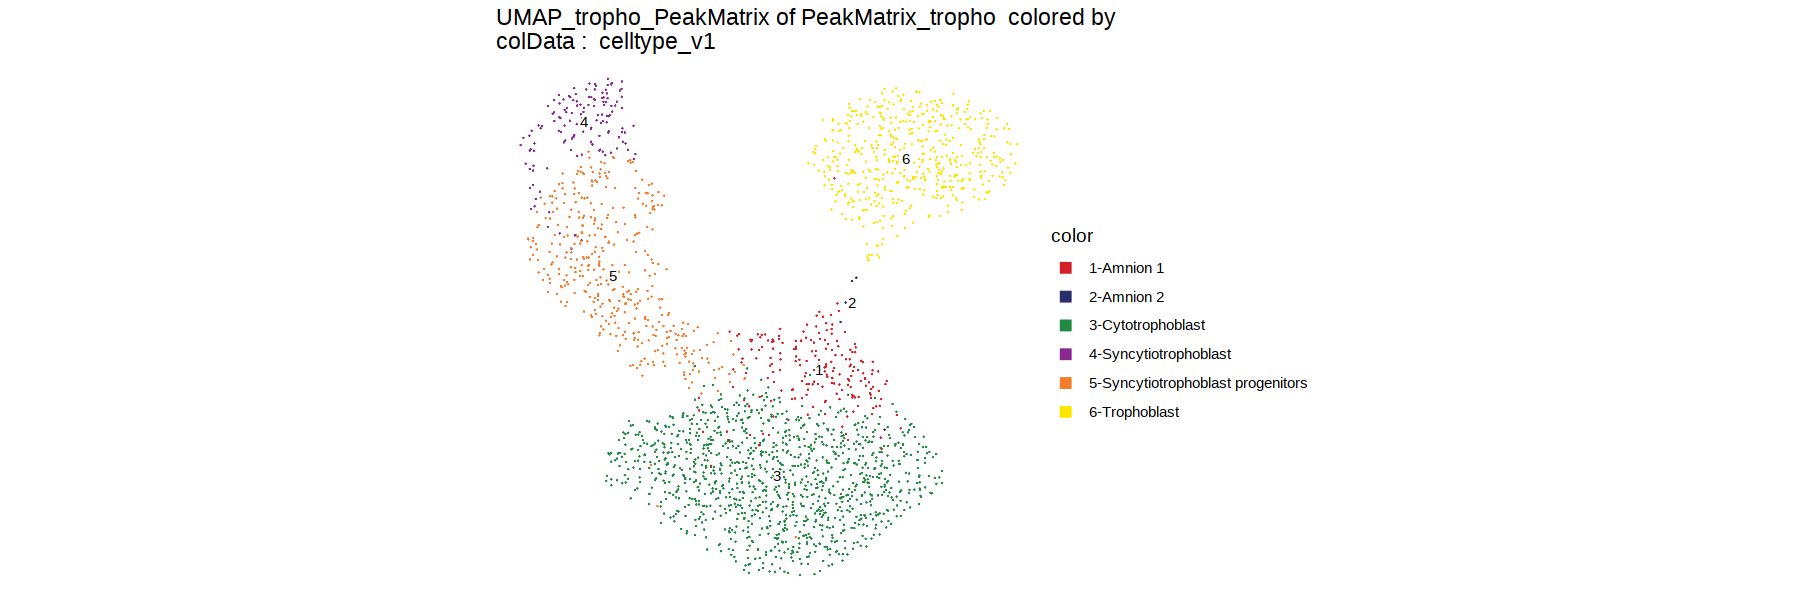

In [7]:
trajectory <- c('Trophoblast', 
                'Cytotrophoblast', 
                'Syncytiotrophoblast Progenitors',
                'Syncytiotrophoblast'
                )

meta = as.data.table(ArchRProject@cellColData)
keep = meta[celltype_tropho %in% trajectory]$cell
subset = ArchRProject[keep]
subset = suppressMessages(dim_redu(subset, ndims=10, nfeatures=15000, n_neighbors=35,min_dist=0.8 ))

In [8]:
trajectory <- c('Trophoblast', 
                'Cytotrophoblast', 
                'Syncytiotrophoblast Progenitors',
                'Syncytiotrophoblast'
                )

subset <- addTrajectory(
    ArchRProj = subset, 
    name = "Tropho", 
    groupBy = "celltype_tropho",
    trajectory = trajectory, 
    embedding = "UMAP_tropho_PeakMatrix",  ### Redudims but may look better based on embeddings
    force = TRUE
)

# exporting motif data for Dan so he can make one plot with RNA + ATAC
# Get gene score matrix
Motif = getMatrixFromProject(
  ArchRProj = subset,
  useMatrix = "MotifMatrix")

# Rename columns & rows
gene_names = sapply(strsplit(Motif@elementMetadata$name,"_"), `[`, 1)
Motif = Motif@assays@data$z
rownames(Motif) = gene_names

meta = as.data.table(subset@cellColData, keep.rownames=TRUE)[,c('rn', 'sample', 'stage', 'celltype_tropho', 'Tropho', 'Clusters')] %>%
    setnames(c('rn', 'Tropho'), c('cell', 'Pseudotime'))

Warning message in .local(x, row.names, optional, ...):
“Arguments in '...' ignored”


Warning message:
“Removed 4 row(s) containing missing values (geom_path).”
Warning message:
“Removed 4 row(s) containing missing values (geom_path).”


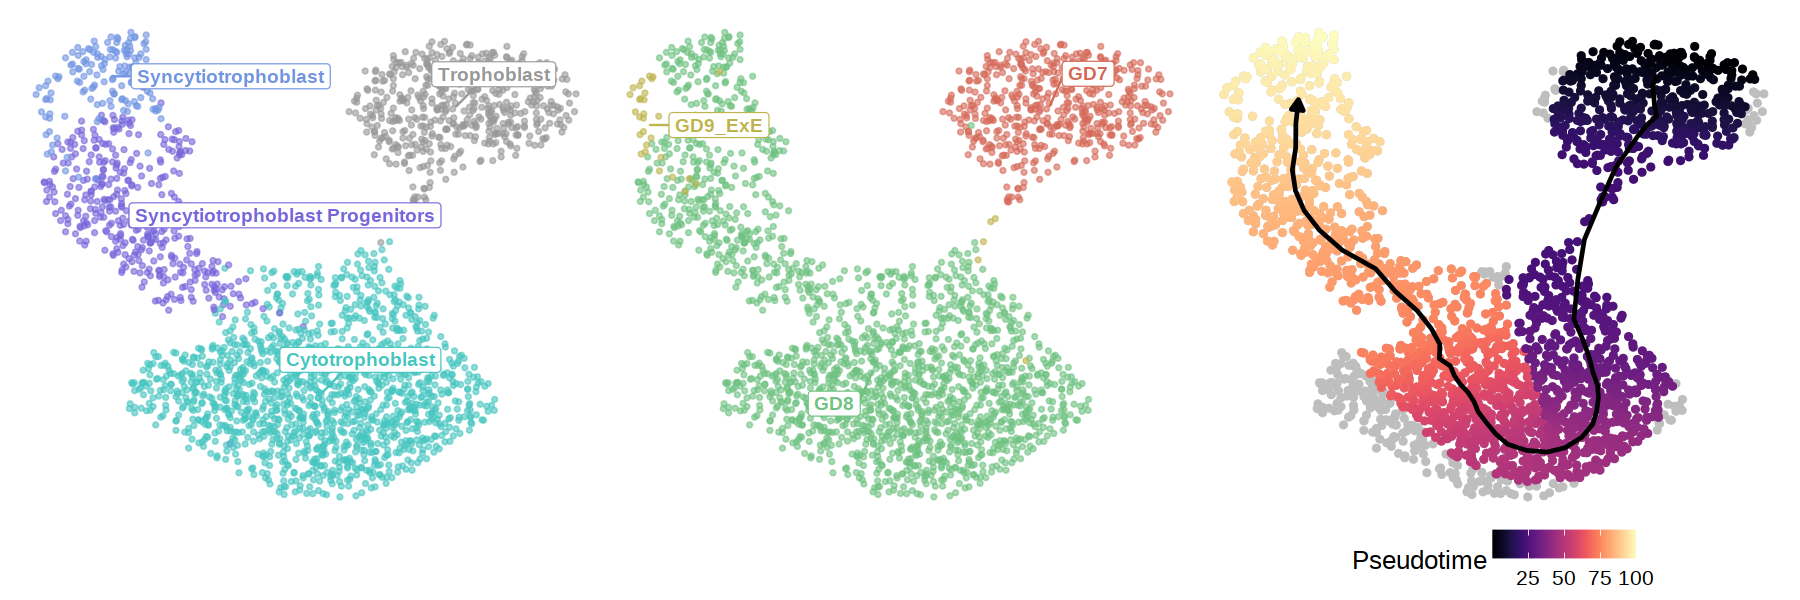

In [9]:
# Fetch UMAP coordinates
umap.dt <- getEmbedding(subset,paste0("UMAP_tropho_PeakMatrix")) %>%
  round(2) %>%
  as.data.table(keep.rownames = T) %>%
  setnames(c("cell","umap1","umap2"))

# Plot
sample_metadata = as.data.frame(getCellColData(subset))
to.plot <- umap.dt %>%
  merge(sample_metadata,by="cell")

p1 = plot_umap('celltype_tropho') + scale_color_manual(values=opts$celltype_colours)
p2 = plot_umap('stage') + scale_color_manual(values=opts$stage.colors)

# Add arrow
bin = 2
k = 5

to.plot$pseudobin = cut(to.plot$Tropho, breaks=seq(0, 100, bin))
arrow = to.plot[!is.na(Tropho),list(median(umap1), median(umap2)), 
                                  by= pseudobin] %>%
        setnames(c('V1', 'V2'), c('umap1', 'umap2')) %>% .[order(pseudobin),]
# Smooth out the arrow
arrow = arrow[,c('smooth1', 'smooth2'):=list(frollmean(umap1, n = k, align = "right"),
                                      frollmean(umap2, n = k, align = "right"))]

p3 = ggplot(to.plot, aes(umap1, umap2)) + 
        geom_point(col='grey') + 
        geom_point(data=to.plot[!is.na(to.plot$Tropho),], aes(umap1, umap2, col=Tropho)) + 
        scale_color_viridis(option='magma', name='Pseudotime') + 
        theme_void() + theme(text=element_text(size=15), legend.position='bottom') +
        geom_path(data=arrow, aes(smooth1,smooth2),
                  size=1, 
                  arrow = arrow(type = "closed", angle = 30, length = unit(0.1, "inches")))

p4 = as_ggplot(get_legend(p3))

p1 + p2 + p3

In [10]:
# export final figure
pdf(sprintf("%s/ATAC_trophoblast_umaps.pdf",io$main_figures), width=7, height=7)
    p1
    p2
    p3 + theme(legend.position='none')
    p4
dev.off()

Warning message:
“Removed 4 row(s) containing missing values (geom_path).”


png 
  2

Creating Trajectory Group Matrix..

Some values are below 0, this could be a DeviationsMatrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...

2022-05-13 13:41:51 : SuppressedMessaged due to getArchRVerbose() is FALSE!

2022-05-13 13:41:51 : SuppressedMessaged due to getArchRVerbose() is FALSE!

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



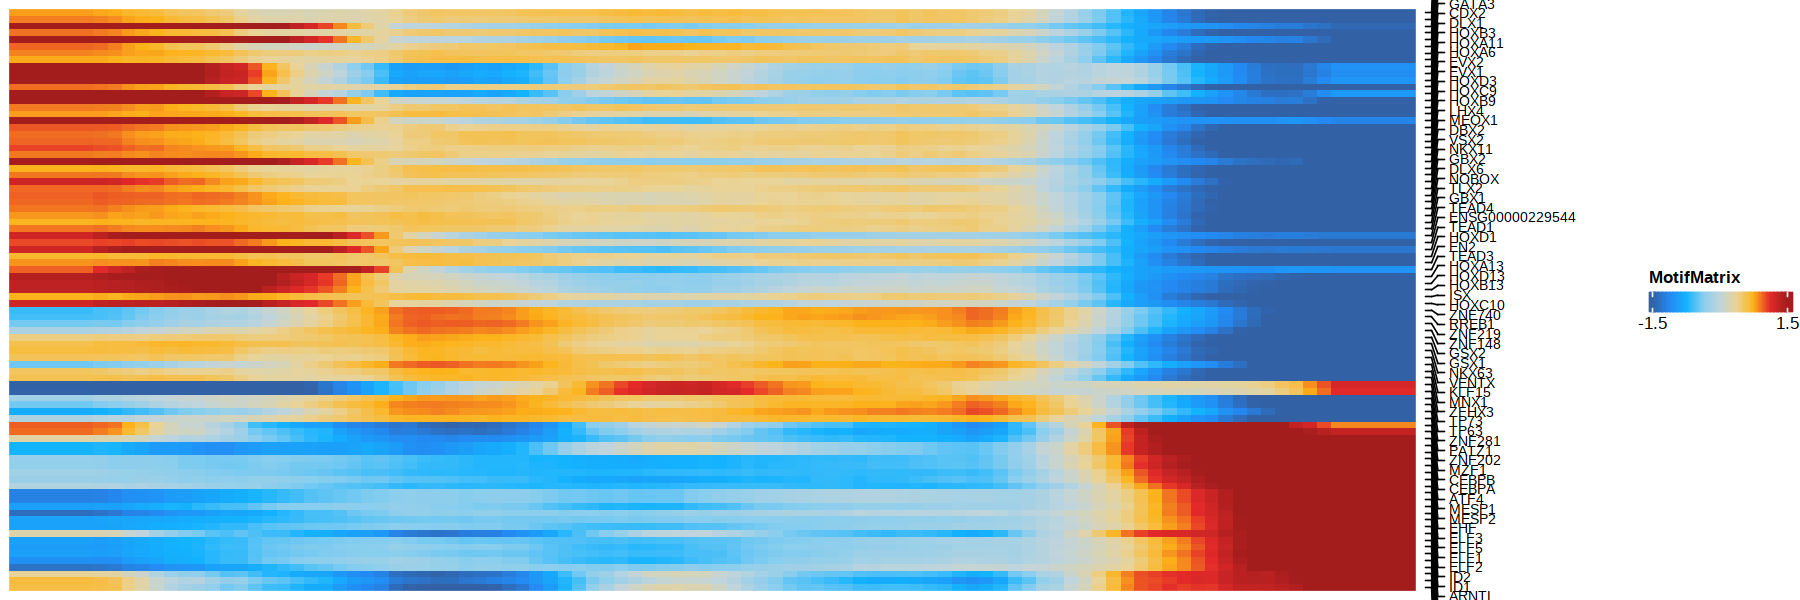

In [13]:
trajMM  <- getTrajectory(ArchRProj = subset, name = "Tropho", useMatrix = "MotifMatrix", log2Norm = FALSE)
names = sapply(strsplit(rownames(trajMM),":"), `[`, 2)
names = sapply(strsplit(names,"_"), `[`, 1)
rownames(trajMM) = names

p1 = plotTrajectoryHeatmap(trajMM, pal = paletteContinuous(set = "solarExtra"), labelTop  = 100)
p1

#### Motif Accessibility vs Expression

In [14]:
atac_meta = as.data.table(subset@cellColData, keep.rownames=TRUE)

Warning message in .local(x, row.names, optional, ...):
“Arguments in '...' ignored”


In [15]:
Motif = getMatrixFromProject(
  ArchRProj = subset,
  useMatrix = "MotifMatrix")

# Rename columns & rows
gene_names = sapply(strsplit(Motif@elementMetadata$name,"_"), `[`, 1)
Motif = Motif@assays@data$z
rownames(Motif) = gene_names

In [69]:
#### Read RNA ####
io$RNA_in <- file.path(io$basedir,"RNA/sce.rds")
sceRNA = readRDS(io$RNA_in)

rna_meta = as.data.table(colData(sceRNA))

# keep trophoblast
rna_meta = rna_meta[celltype %in% c('Trophoblast', 'Cytotrophoblast', 'Syncytiotrophoblast', 'Syncytiotrophoblast progenitors')]
tropho_RNA = sceRNA[,rna_meta$cell]

In [70]:
unique(colData(tropho_RNA)$celltype)

[1] "Cytotrophoblast"                 "Trophoblast"                    
[3] "Syncytiotrophoblast progenitors" "Syncytiotrophoblast"

In [17]:
# Get ATAC motif values
get_motif_means = function(ct){
    cells = atac_meta[celltype_tropho==ct]$rn
    motif_ct = Motif[,cells]
    motif_ct = rowMeans(motif_ct)
    motif_ct = as.data.table(motif_ct) %>% setnames(c('motif_ct'), c(ct))

}
# Calculate means per celltype for ATAC
motif_means = do.call(cbind, 
                      lapply(unique(atac_meta$celltype_tropho), get_motif_means)) %>% 
                        .[,c('TF', 'assay'):=list(rownames(Motif), 'ATAC')] %>%
                        melt(id.vars=c('TF', 'assay')) %>% 
                        setnames('variable', 'celltype')

In [74]:
# Extract TFs of RNA data
tropho_RNA_TFs = tropho_RNA[rownames(tropho_RNA)[rownames(tropho_RNA) %in% rownames(Motif)],]

In [77]:
# Calculate means per celltype for RNA
get_expr_means = function(ct){
    cells = rna_meta[celltype==ct]$cell
    expr_ct = tropho_RNA_TFs@assays@data$logcounts[,cells]
    expr_ct = rowMeans(expr_ct)
    expr_ct = as.data.table(expr_ct) %>% setnames(c('expr_ct'), c(ct))
}

expr_means = do.call(cbind, 
                      lapply(unique(rna_meta$celltype), get_expr_means)) %>% 
                         .[,c('TF', 'assay'):=list(rownames(tropho_RNA_TFs), 'RNA')]  %>%
                         melt(id.vars=c('TF', 'assay')) %>% 
                         setnames('variable', 'celltype')

#only keep genes with some expression
expressed_TFs = expr_means %>% .[,max:=max(value), by=TF] %>% .[max>0.1] %>% .$TF %>% unique()

In [78]:
# Keep only motifs of TFs present in ATAC & RNA
motifs_keep = intersect(motif_means$TF, expressed_TFs)

In [79]:
rna_motif = rbind(motif_means, expr_means[,c('TF', 'assay', 'celltype', 'value')])[TF %in% motifs_keep] 

In [80]:
# Match celltype names between ATAC & RNA
rna_motif$celltype = gsub("(^|[[:space:]])([[:alpha:]])", "\\1\\U\\2",    # Uppercase with Base R
     rna_motif$celltype,
     perl = TRUE)
rna_motif$celltype = gsub(' 1', '', rna_motif$celltype)

In [81]:
rna_motif = dcast(rna_motif, TF+celltype ~ assay, value.var = "value") %>% 
    .[,celltype:=factor(celltype, levels=c('Trophoblast', 'Cytotrophoblast', 'Syncytiotrophoblast Progenitors', 'Syncytiotrophoblast'))] %>% 
    .[order(TF, celltype)]

In [82]:
# function to correlate RNA & ATAC score (linear correlation)

calc_corr = function(TFi){
    tmp = rna_motif[TF==TFi]
    cor = cor.test(tmp$ATAC, tmp$RNA)
    cor = as.data.table(t(unlist(cor)), keep.rownames=TRUE) %>%
    .[,TF:=TFi] %>% .[,c('TF', 'statistic.t','p.value','estimate.cor')] %>%
    .[,c('p.value', 'estimate.cor'):=list(as.numeric(p.value), as.numeric(estimate.cor))]
    return(cor)
}

# calculate correlation between RNA & ATAC between celltypes for all TFs 
TF_corr = suppressWarnings(rbindlist(lapply(motifs_keep, calc_corr))) %>%
    .[,FDR:= p.adjust(p.value, 'BH')]

In [83]:
plot_RNA_motif = 
    function(TFs='DLX5'){
        if(TFs %in% motifs_keep)
            ggplot(rna_motif[TF==TFs], aes(RNA, ATAC, label=celltype)) + 
                geom_point(aes(size = 5, col=celltype)) + 
                geom_path(arrow = arrow(length=unit(0.45,"cm"), ends="last", type = "closed"), size=0.8) + 
                xlab('Log2 Norm RNA Expression') + ylab('TF Motif Enrichment Score') + 
             #   ggrepel::geom_label_repel(box.padding = 0.9, max.overlaps = Inf, min.segment.length=2) + 
                scale_color_manual(values=opts$celltype_colours) + 
                ggtitle(TFs) +
                scale_x_continuous(limits=c(0,max(rna_motif[TF==TFs]$RNA))) + 
                theme_bw() +
                theme(text = element_text(size = 15),
                      legend.position='none',
                      axis.text = element_text(colour = "black"))
     }

In [84]:
library(patchwork)

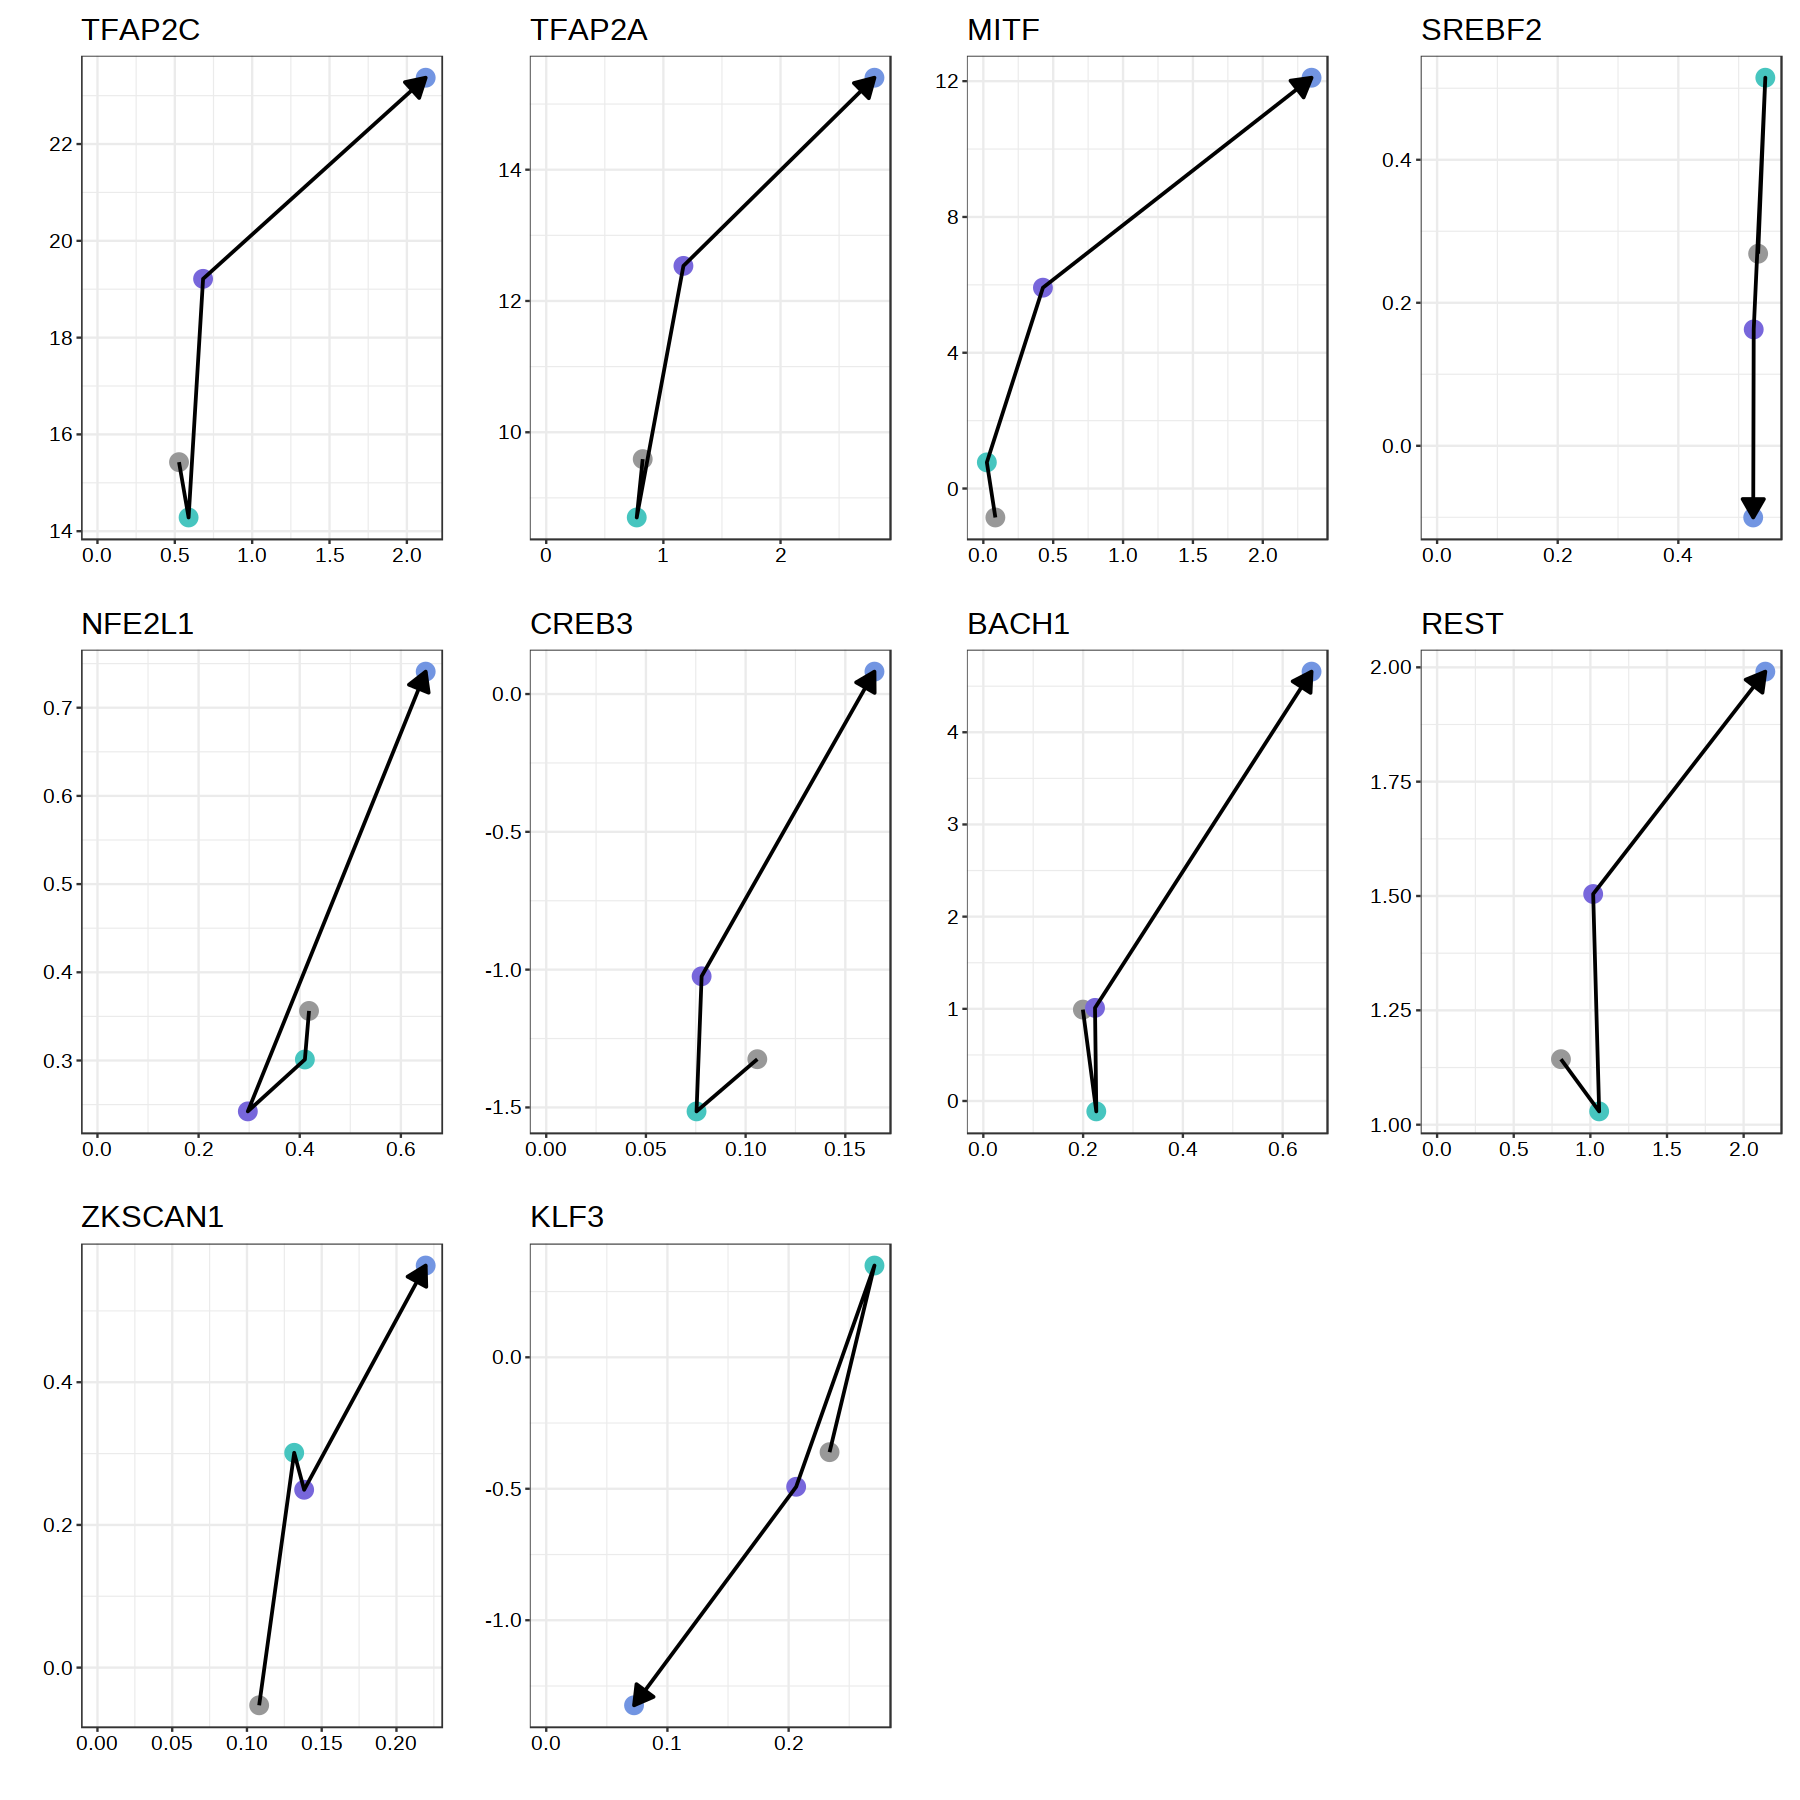

In [85]:
TF_selected = lapply(TF_corr[estimate.cor>0.8]$TF, plot_RNA_motif)
options(repr.plot.width=15, repr.plot.height=15)

(wrap_plots(TF_selected[1:10]) & xlab('') & ylab(''))

In [86]:
# Save plot
pdf(sprintf("%s/ATAC_supp_RNA_Motif_corr.pdf",io$sup_figures), width=15, height=35)
    (wrap_plots(TF_selected, ncol=4) & xlab('') & ylab('')) + xlab('Log2 Norm RNA Expression') + ylab('TF Motif Enrichment Score')
dev.off()

png 
  2

#### Plot correlated & known genes

In [87]:
# Get in long format, add meta, add zscore, smooth
plot_motif = as.data.table(as.matrix(Motif)) %>%
     .[,TF:=gene_names] %>% 
     melt(id.vars = 'TF') %>%
    .[,zscore:= scale(value), by=TF] %>% 
     setnames('variable','cell') %>% 
    merge(meta, by='cell') %>%
    .[order(Pseudotime)] %>%  
    .[, zscore_smooth:=frollmean(zscore, 10), by = TF] %>% # smooth by 10 cells
    .[, zscore_smooth:= ifelse(is.na(zscore_smooth), zscore, zscore_smooth)] %>% # give first 10 cells raw values
    .[,zscore_capped:=ifelse(zscore>=1.5, 1.5, ifelse(zscore<=-1.5, -1.5, zscore))] %>%
    .[,zscore_smooth_capped:=ifelse(zscore_smooth>=1.5, 1.5, ifelse(zscore_smooth<=-1.5, -1.5, zscore_smooth))]

In [88]:
plot_meta = plot_motif %>% unique(by='cell') %>% .[,c('Pseudotime', 'Clusters', 'celltype_tropho')] %>% melt(id.vars='Pseudotime')

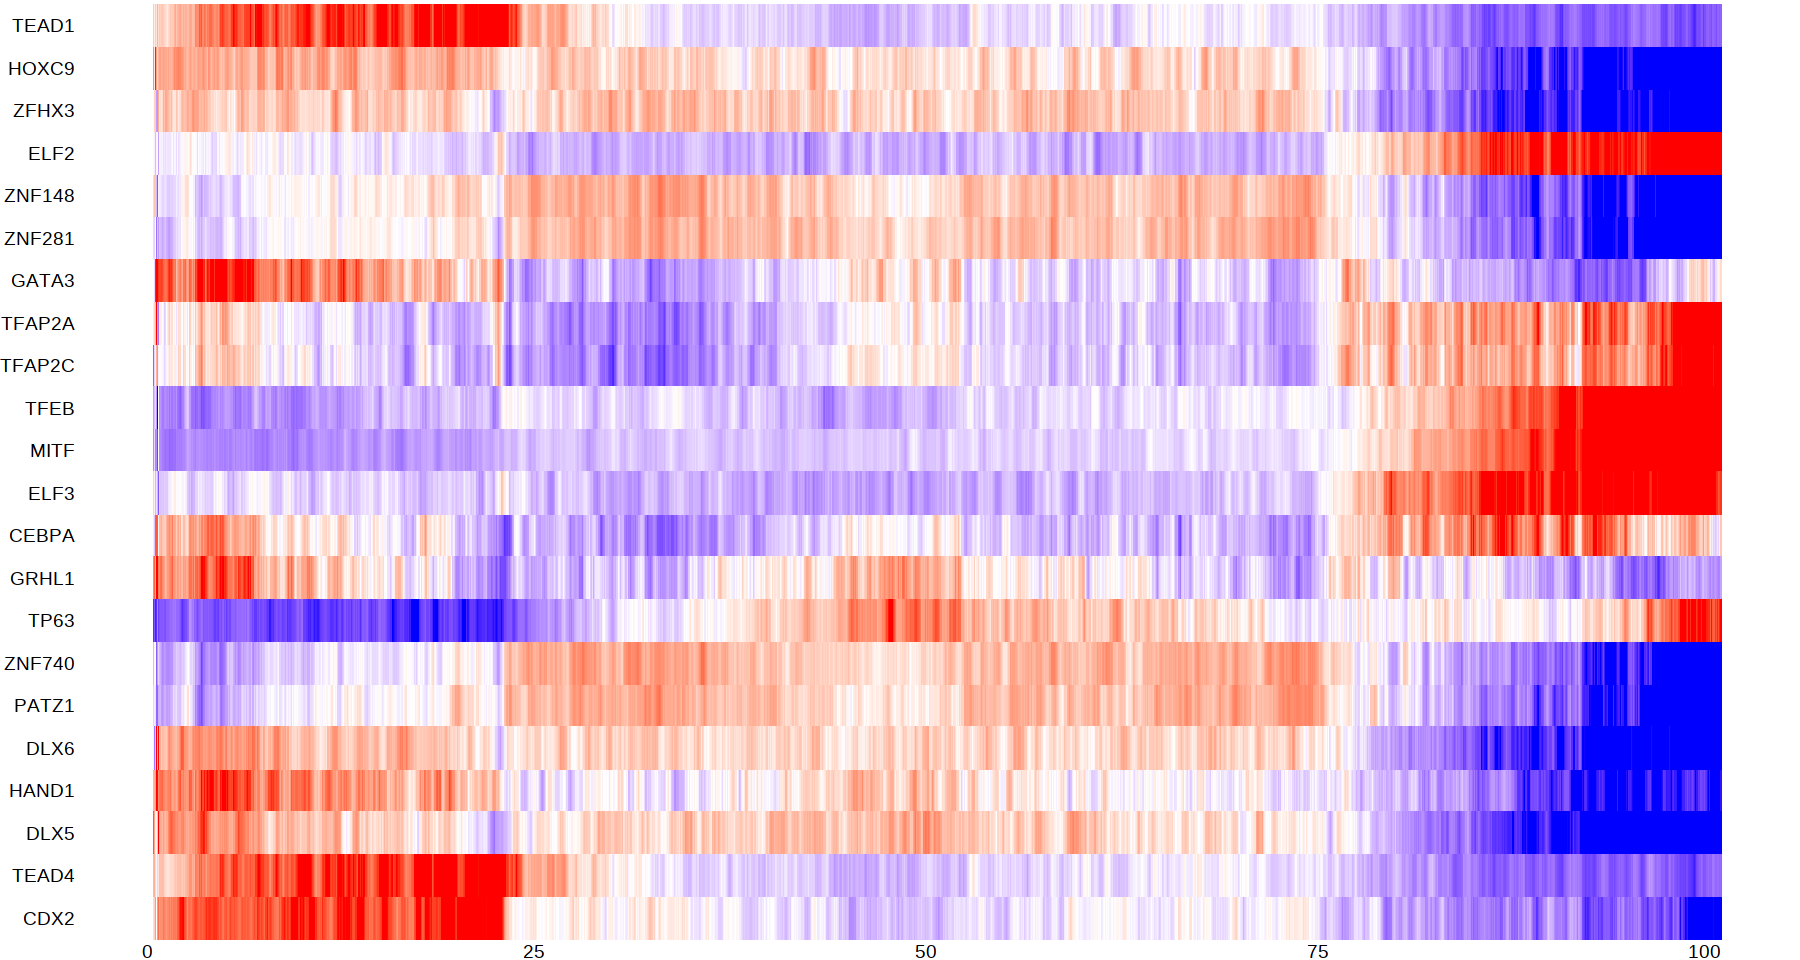

In [89]:
  TF_plot = c("CDX2", "TEAD4", "DLX5", "HAND1", "DLX6","PATZ1", "ZNF740",
  "TP63", "GRHL1", "CEBPA","ELF3", "MITF", "TFEB","TFAP2C", "TFAP2A", "GATA3")
options(repr.plot.width=15, repr.plot.height=8)
#TF_plot = ''
correlated = intersect(TF_corr[estimate.cor>0.8]$TF, rownames(p1@ht_list$MotifMatrix@matrix))
#correlated = TF_corr[estimate.cor>0.8]$TF
TF_plot = unique(c(TF_plot, correlated))

# ggplot(plot_motif[TF %in% TF_plot & !is.na(Pseudotime)], 
#        aes(Pseudotime,factor(TF, levels=TF_plot), fill=zscore_capped)) + 
#     geom_tile() + 
#     scale_fill_gradient2(low = "blue", mid = "white", high = "red") + 
#     theme_void() + 
#     theme(axis.text = element_text(hjust=1), legend.position='none')
ggplot(plot_motif[TF %in% TF_plot & !is.na(Pseudotime)], 
       aes(Pseudotime,factor(TF, levels=TF_plot), fill=zscore_smooth_capped)) + 
    geom_tile() + scale_fill_gradient2(low = "blue", mid = "white", high = "red") + 
    theme_void() + 
    theme(axis.text = element_text(hjust=1), legend.position='none')

In [90]:
## Export data for Dan's RNA + ATAC heatmap
# Export raw data
meta = as.data.table(subset@cellColData, keep.rownames=TRUE)[,c('rn', 'sample', 'stage', 'celltype_tropho', 'Tropho')] %>%
    setnames(c('rn', 'Tropho'), c('cell', 'Pseudotime'))
meta$cell = gsub('#', '.', meta$cell)
meta$cell = gsub('-', '.', meta$cell)

write.csv(meta, file.path(io$basedir, 'ArchR/Trophoblast/trophoblast_atac_meta.csv'), row.names=FALSE)
write.csv(Motif, file.path(io$basedir, 'ArchR/Trophoblast/trophoblast_atac_motifs.csv'), row.names=TRUE)

## Export processed datatable
write.csv(plot_motif[TF %in% TF_plot & !is.na(Pseudotime)], file.path(io$basedir, 'ArchR/Trophoblast/trophoblast_atac_motifs_processed.csv'), row.names=FALSE)

Warning message in .local(x, row.names, optional, ...):
“Arguments in '...' ignored”


In [37]:
subset = addImputeWeights(subset, 'PeakMatrix_tropho')

Warning message in sprintf("Completed Getting Magic Weights!", round(object.size(weightList)/10^9, :
“one argument not used by format 'Completed Getting Magic Weights!'”


In [38]:
imputed_motif = suppressMessages(imputeMatrix(mat = as.matrix(Motif), 
                                imputeWeights = getImputeWeights(subset)))

In [48]:
# Get in long format, add meta, add zscore, smooth
plot_motif = as.data.table(imputed_motif) %>%
     .[,TF:=gene_names] %>% 
     melt(id.vars = 'TF') %>%
    .[,zscore:= scale(value), by=TF] %>% 
     setnames('variable','cell') %>% 
    merge(meta, by='cell') %>%
    .[order(Pseudotime)] %>%  
    .[, zscore_smooth:=frollmean(zscore, 10), by = TF] %>% 
    .[,zscore_capped:=ifelse(zscore>=1.5, 1.5, ifelse(zscore<=-1.5, -1.5, zscore))] %>%
    .[,zscore_smooth_capped:=ifelse(zscore_smooth>=1.5, 1.5, ifelse(zscore_smooth<=-1.5, -1.5, zscore_smooth))]

In [49]:
plot = function(gene){
    ggplot(plot_motif[TF == gene & !is.na(Pseudotime)], aes(Pseudotime, value, col=value)) +
        geom_point() +
        scale_color_viridis(option='viridis', name='motif') +
        geom_smooth(col='black') + 
        xlab('Pseudotime') + ylab('Motif Accessibility') + 
        ggtitle(gene) +
        theme_classic() + 
        theme(text = element_text(size = 15), 
              legend.title=element_text(size=10))
}

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



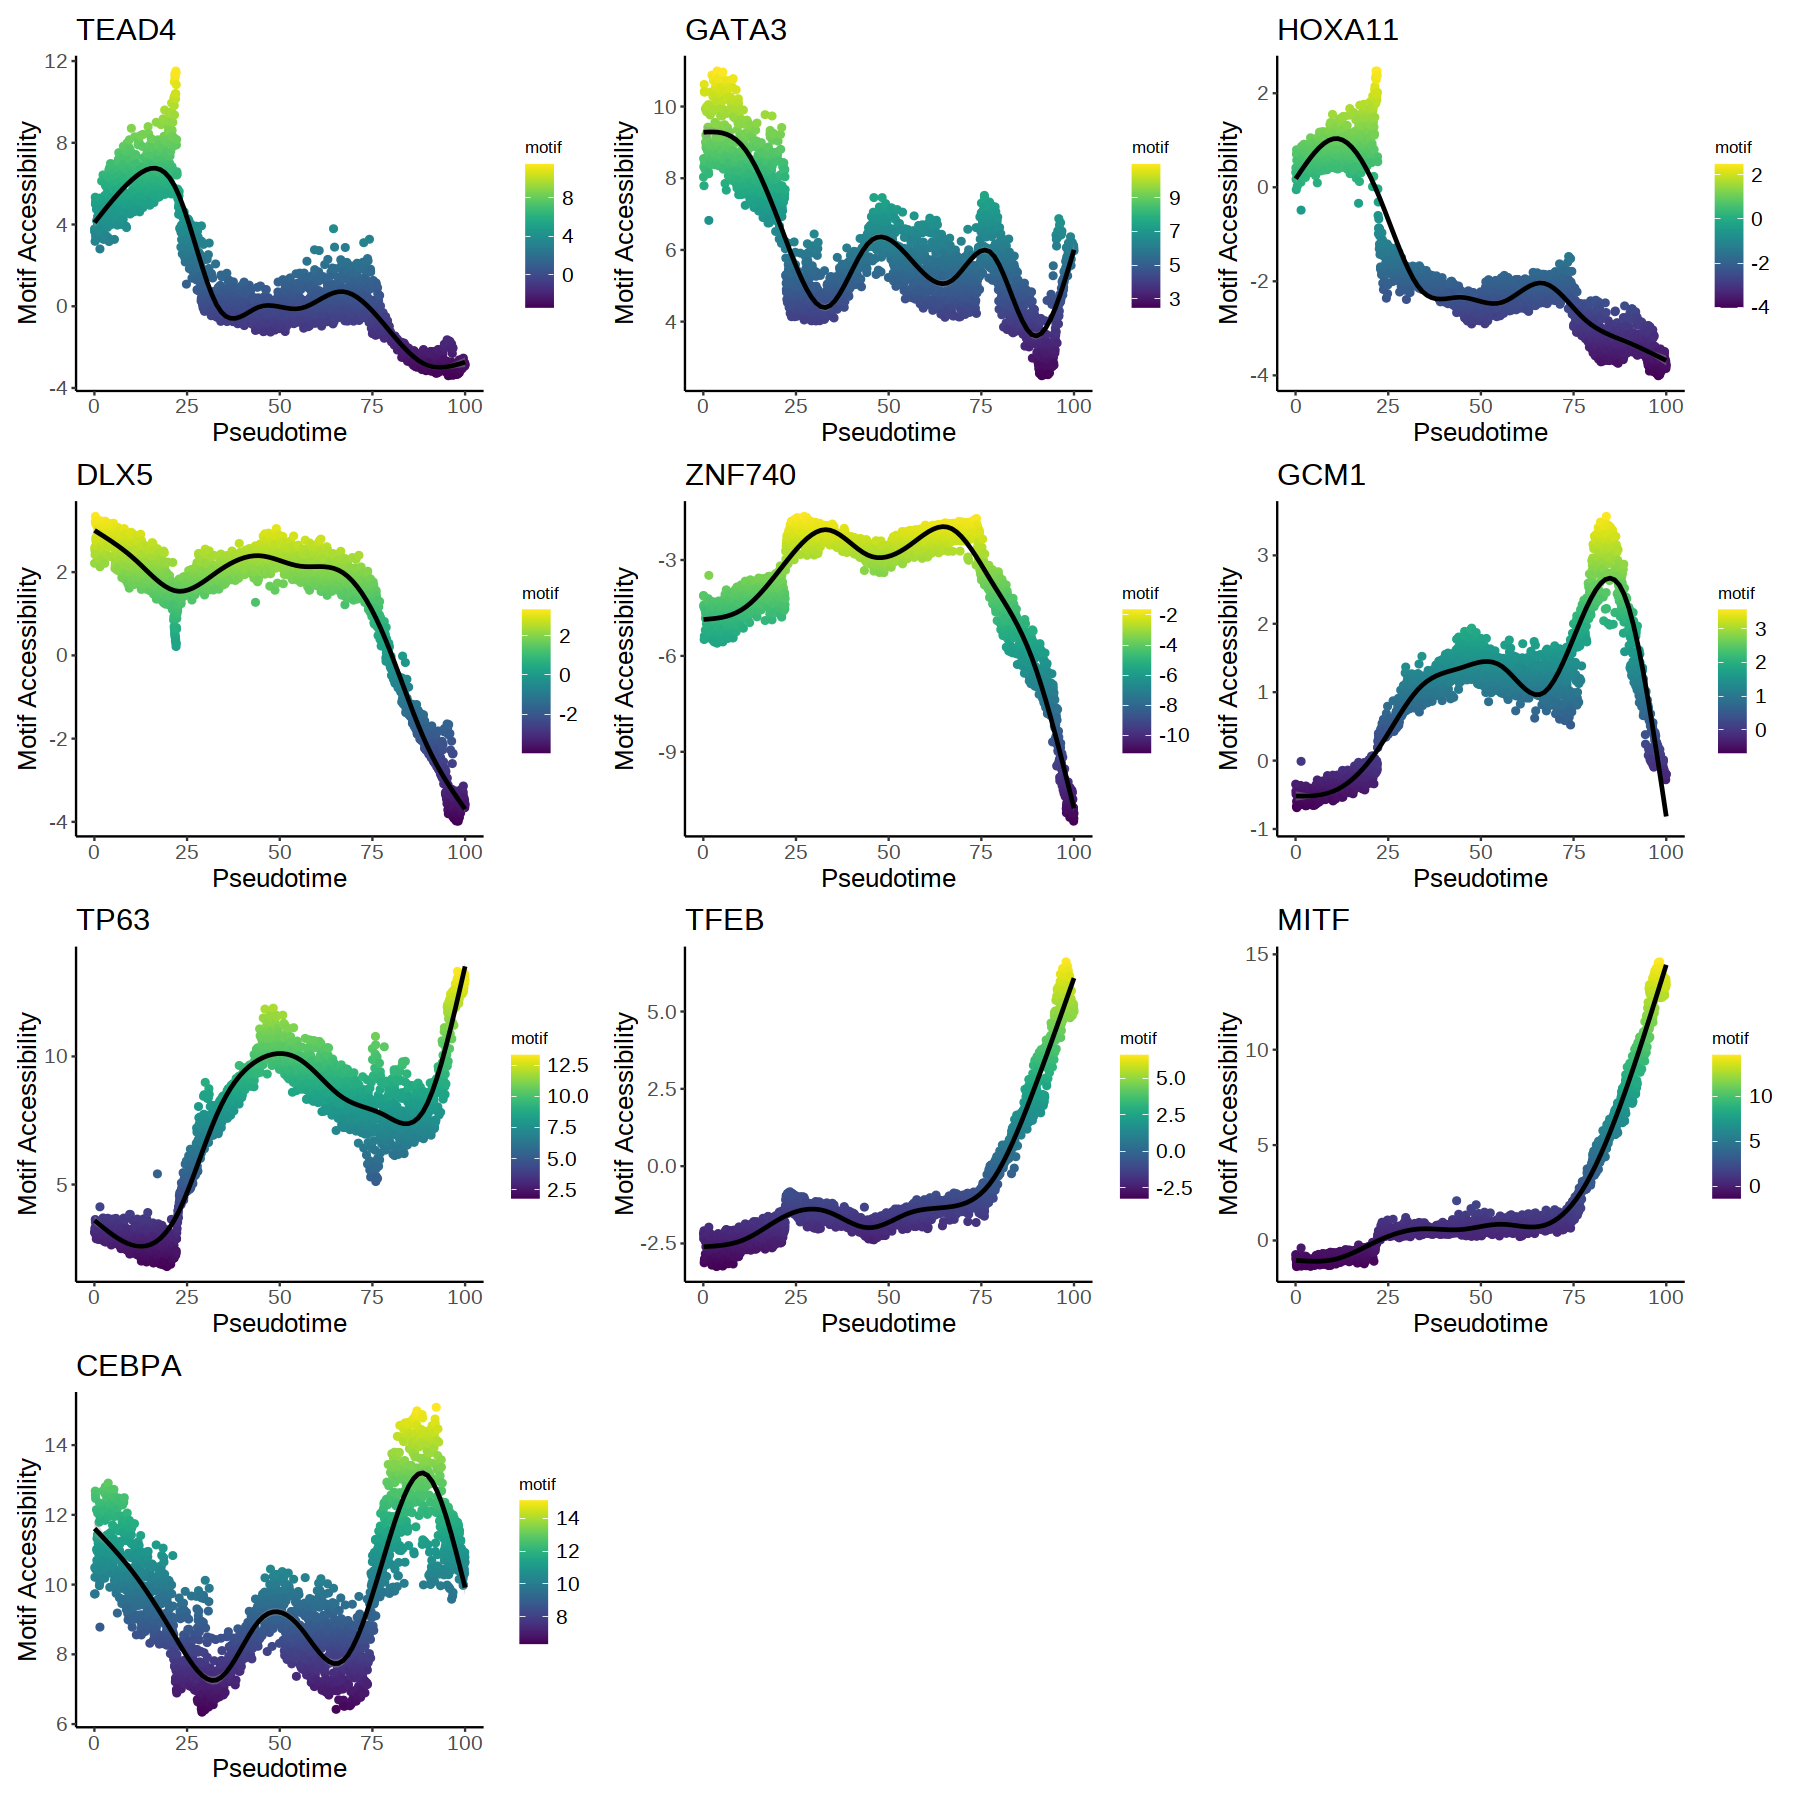

In [50]:
marker_genes = c('TEAD4', 'GATA3', 'HOXA11', 'DLX5', 'ZNF740', 'GCM1', 'TP63', 'TFEB', 'MITF', 'CEBPA')
TF_selected = lapply(marker_genes, plot)
options(repr.plot.width=15, repr.plot.height=15)

(wrap_plots(TF_selected, ncol = 3))

In [54]:
# Save plot
pdf(sprintf("%s/ATAC_supp_pseudotime_genes.pdf",io$sup_figures), width=15, height=10)
    (wrap_plots(TF_selected, ncol=3))
dev.off()

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



png 
  2

#### Plot DLX5/6 UMAP

In [12]:
Motif = getMatrixFromProject(
  ArchRProj = subset,
  useMatrix = "MotifMatrix")

# Rename columns & rows
gene_names = sapply(strsplit(Motif@elementMetadata$name,"_"), `[`, 1)
Motif = Motif@assays@data$z
rownames(Motif) = gene_names

In [39]:
DLXs = as.data.table(t(imputed_motif[c('DLX5', 'DLX6'),]), keep.rownames=TRUE) %>% setnames('rn', 'cell')

In [40]:
head(DLXs)

cell                             DLX5      DLX6       
1 rabbit_BGRGP3#GCGAGTCAGAGGTCCA-1  2.609864 -0.07888227
2 rabbit_BGRGP3#CTTGCTGGTTTGTCTT-1 -3.500988 -4.51556319
3 rabbit_BGRGP3#ACAATCGCACAAGGGT-1 -3.983441 -5.06040260
4 rabbit_BGRGP3#GTGTCCTCAATGCCAT-1 -2.293933 -3.76545182
5 rabbit_BGRGP3#GCTGTTCTCTACCCGT-1  2.927580 -0.04551224
6 rabbit_BGRGP3#AAAGATGCACTAGGAG-1 -3.660000 -4.70322095

In [41]:
dlx_umap = merge(to.plot, DLXs, by='cell')

In [42]:
head(dlx_umap)

cell                             umap1 umap2 Sample        TSSEnrichment
1 rabbit_BGRGP1#AAACGAAAGTTTGGAA-1 1.93  7.99  rabbit_BGRGP1 4.165        
2 rabbit_BGRGP1#AAACGAACAAGAGCGT-1 6.45  8.13  rabbit_BGRGP1 4.629        
3 rabbit_BGRGP1#AAACTGCAGTGTTCCA-1 4.19  7.48  rabbit_BGRGP1 3.724        
4 rabbit_BGRGP1#AAACTGCTCATCGCTC-1 2.26  8.00  rabbit_BGRGP1 4.270        
5 rabbit_BGRGP1#AAACTGCTCGGTCAGC-1 6.62  7.47  rabbit_BGRGP1 5.292        
6 rabbit_BGRGP1#AACAGTCAGAGGTCCA-1 6.18  9.35  rabbit_BGRGP1 4.022        
  ReadsInTSS ReadsInPromoter PromoterRatio PassQC NucleosomeRatio ⋯ celltype_v1
1 856        7642            0.10807829    1      1.2267431       ⋯ Trophoblast
2 713        6562            0.11023384    1      0.9514818       ⋯ Trophoblast
3 613        5785            0.09179917    1      1.4647215       ⋯ Trophoblast
4 511        4448            0.09691899    1      1.2627946       ⋯ Trophoblast
5 449        3929            0.11398979    1      1.2143132       ⋯ Trophoblast
6 851        7975            0.10212837    1      1.2081213       ⋯ Trophoblast
  Clusters predictedCell_TrohpoPeakMatrix_tropho
1 C1       cell_8883                            
2 C1       cell_107816                          
3 C1       cell_15983                           
4 C1       cell_130991                          
5 C1       cell_106523                          
6 C1       cell_141451                          
  celltype_TrophoPeakMatrix_tropho score_TrophoPeakMatrix_tropho
1 Trophoblast                      0.6354073                    
2 Amnion 2                         0.3859077                    
3 Trophoblast                      0.4052802                    
4 Amnion 2                         0.4192063                    
5 Cytotrophoblast                  0.3755347                    
6 Amnion 3                         0.3264860                    
  celltype_tropho Tropho    pseudobin DLX5     DLX6     
1 Trophoblast     12.994877 (12,14]   2.452005 0.4700558
2 Trophoblast      8.616674 (8,10]    1.864372 0.1019485
3 Trophoblast     13.553796 (12,14]   1.887032 0.2363816
4 Trophoblast     12.761993 (12,14]   2.618632 0.6287202
5 Trophoblast            NA NA        1.614298 0.1309245
6 Trophoblast      3.167210 (2,4]     2.435847 0.4267937

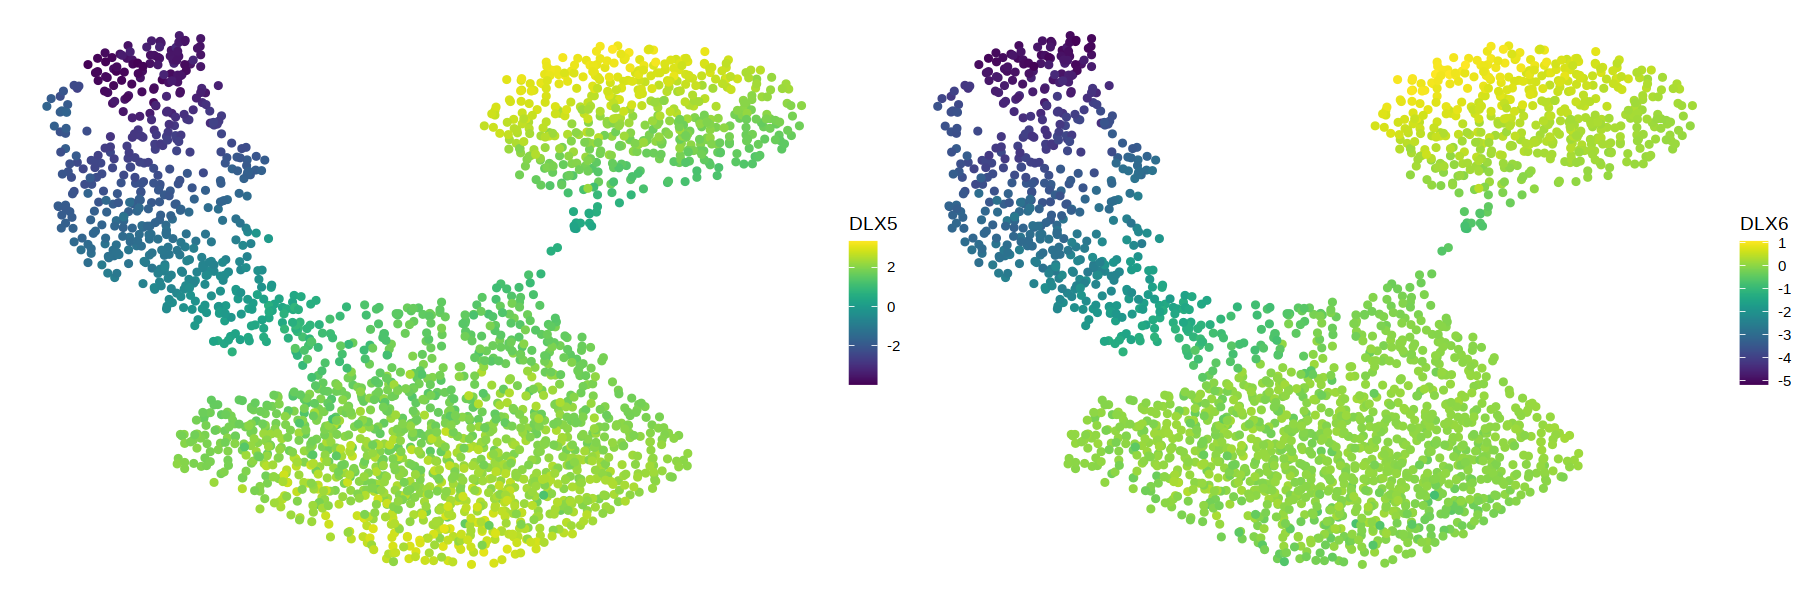

In [45]:
ggplot(dlx_umap, aes(umap1, umap2, col=DLX5)) + geom_point()+ scale_color_viridis()+ theme_void() + ggplot(dlx_umap, aes(umap1, umap2, col=DLX6)) + geom_point()+ scale_color_viridis()+ theme_void()

In [46]:
head(dlx_umap)

cell                             umap1 umap2 Sample        TSSEnrichment
1 rabbit_BGRGP1#AAACGAAAGTTTGGAA-1 1.93  7.99  rabbit_BGRGP1 4.165        
2 rabbit_BGRGP1#AAACGAACAAGAGCGT-1 6.45  8.13  rabbit_BGRGP1 4.629        
3 rabbit_BGRGP1#AAACTGCAGTGTTCCA-1 4.19  7.48  rabbit_BGRGP1 3.724        
4 rabbit_BGRGP1#AAACTGCTCATCGCTC-1 2.26  8.00  rabbit_BGRGP1 4.270        
5 rabbit_BGRGP1#AAACTGCTCGGTCAGC-1 6.62  7.47  rabbit_BGRGP1 5.292        
6 rabbit_BGRGP1#AACAGTCAGAGGTCCA-1 6.18  9.35  rabbit_BGRGP1 4.022        
  ReadsInTSS ReadsInPromoter PromoterRatio PassQC NucleosomeRatio ⋯ celltype_v1
1 856        7642            0.10807829    1      1.2267431       ⋯ Trophoblast
2 713        6562            0.11023384    1      0.9514818       ⋯ Trophoblast
3 613        5785            0.09179917    1      1.4647215       ⋯ Trophoblast
4 511        4448            0.09691899    1      1.2627946       ⋯ Trophoblast
5 449        3929            0.11398979    1      1.2143132       ⋯ Trophoblast
6 851        7975            0.10212837    1      1.2081213       ⋯ Trophoblast
  Clusters predictedCell_TrohpoPeakMatrix_tropho
1 C1       cell_8883                            
2 C1       cell_107816                          
3 C1       cell_15983                           
4 C1       cell_130991                          
5 C1       cell_106523                          
6 C1       cell_141451                          
  celltype_TrophoPeakMatrix_tropho score_TrophoPeakMatrix_tropho
1 Trophoblast                      0.6354073                    
2 Amnion 2                         0.3859077                    
3 Trophoblast                      0.4052802                    
4 Amnion 2                         0.4192063                    
5 Cytotrophoblast                  0.3755347                    
6 Amnion 3                         0.3264860                    
  celltype_tropho Tropho    pseudobin DLX5     DLX6     
1 Trophoblast     12.994877 (12,14]   2.452005 0.4700558
2 Trophoblast      8.616674 (8,10]    1.864372 0.1019485
3 Trophoblast     13.553796 (12,14]   1.887032 0.2363816
4 Trophoblast     12.761993 (12,14]   2.618632 0.6287202
5 Trophoblast            NA NA        1.614298 0.1309245
6 Trophoblast      3.167210 (2,4]     2.435847 0.4267937

In [47]:
write.csv(dlx_umap, sprintf("%s/metadata_for_dan.csv",io$main_figures))

#### Export bigwig files per celltype

In [10]:
addArchRThreads(1)

Setting default number of Parallel threads to 1.



In [11]:
getGroupBW(
  ArchRProj = subset,
  groupBy = "celltype_tropho",
  normMethod = "ReadsInTSS",
  tileSize = 101,
  maxCells = 1000) #1000 = default

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Trophoblast/GroupBigWigs/celltype_tropho/Cytotrophoblast-TileSize-101-normMethod-ReadsInTSS-ArchR.bw"                
[2] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Trophoblast/GroupBigWigs/celltype_tropho/Syncytiotrophoblast-TileSize-101-normMethod-ReadsInTSS-ArchR.bw"            
[3] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Trophoblast/GroupBigWigs/celltype_tropho/Syncytiotrophoblast.Progenitors-TileSize-101-normMethod-ReadsInTSS-ArchR.bw"
[4] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Trophoblast/GroupBigWigs/celltype_tropho/Trophoblast-TileSize-101-normMethod-ReadsInTSS-ArchR.bw"

#### BED files for peaks with TFs of interest

In [37]:
matches = getMatches(ArchRProject)

colnames(matches) = sapply(strsplit(colnames(matches), '_'), '[', 1) # rename columns to actual TF names
colnames(matches@assays@data$matches) = sapply(strsplit(colnames(matches), '_'), '[', 1)
rowData(matches)$idx = 1:nrow(rowData(matches))

In [38]:
peaks = getPeakSet(ArchRProject)
peaks$idx = 1:length(peaks)

In [39]:
create_bed = function(TF){
    TF_peak_ids = matches[matches@assays@data$matches[, TF]]@rowRanges$idx
    bed = as.data.table(peaks)[idx %in% TF_peak_ids] %>%
        .[, c('seqnames', 'start', 'end')] %>%
        setnames(c('chr', 'start', 'end')) %>%
        .[,name:=TF]
    return(bed)
}
DLX_bed = rbind(create_bed('DLX5'),create_bed('DLX6'))

In [44]:
fwrite(DLX_bed, file.path(io$basedir, 'ArchR/DLX.bed'), sep='\t', col.names=F)

### Annotation trial including C4 as trophoblast
When plotted along pseudotime it is clear that C4 does not belong to the same trajectory

In [127]:
annotation = data.table(Clusters = paste0('C', 1:9),
                       Tropho_celltype = c('Syncytiotrophoblast', #1
                                           'Syncytiotrophoblast Progenitors', #2
                                           'Trophoblast', #3
                                           'Trophoblast', #4
                                           'Amnion 1', #5 # Tac4, SNX10, PGF
                                           'Amnion 2', #6 
                                           'Trophoblast', #7
                                           'Cytotrophoblast', #8
                                           'Cytotrophoblast' #9 label transfer = amnion 2, but is very similar to cytotropho
                                          ))

annotation = annotation %>% .[match(ArchRProject@cellColData$Clusters, annotation$Clusters),]
ArchRProject@cellColData$celltype_tropho = annotation$Tropho_celltype

In [129]:
trajectory <- c('Trophoblast', 
                'Cytotrophoblast', 
                'Syncytiotrophoblast Progenitors',
                'Syncytiotrophoblast'
                )

ArchRProject <- addTrajectory(
    ArchRProj = ArchRProject, 
    name = "Tropho", 
    groupBy = "celltype_tropho",
    trajectory = trajectory, 
    embedding = "UMAP_tropho_PeakMatrix",  ### Redudims but may look better based on embeddings
    force = TRUE
)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -13.02   -7.45    2.69    0.00    6.05    9.64 

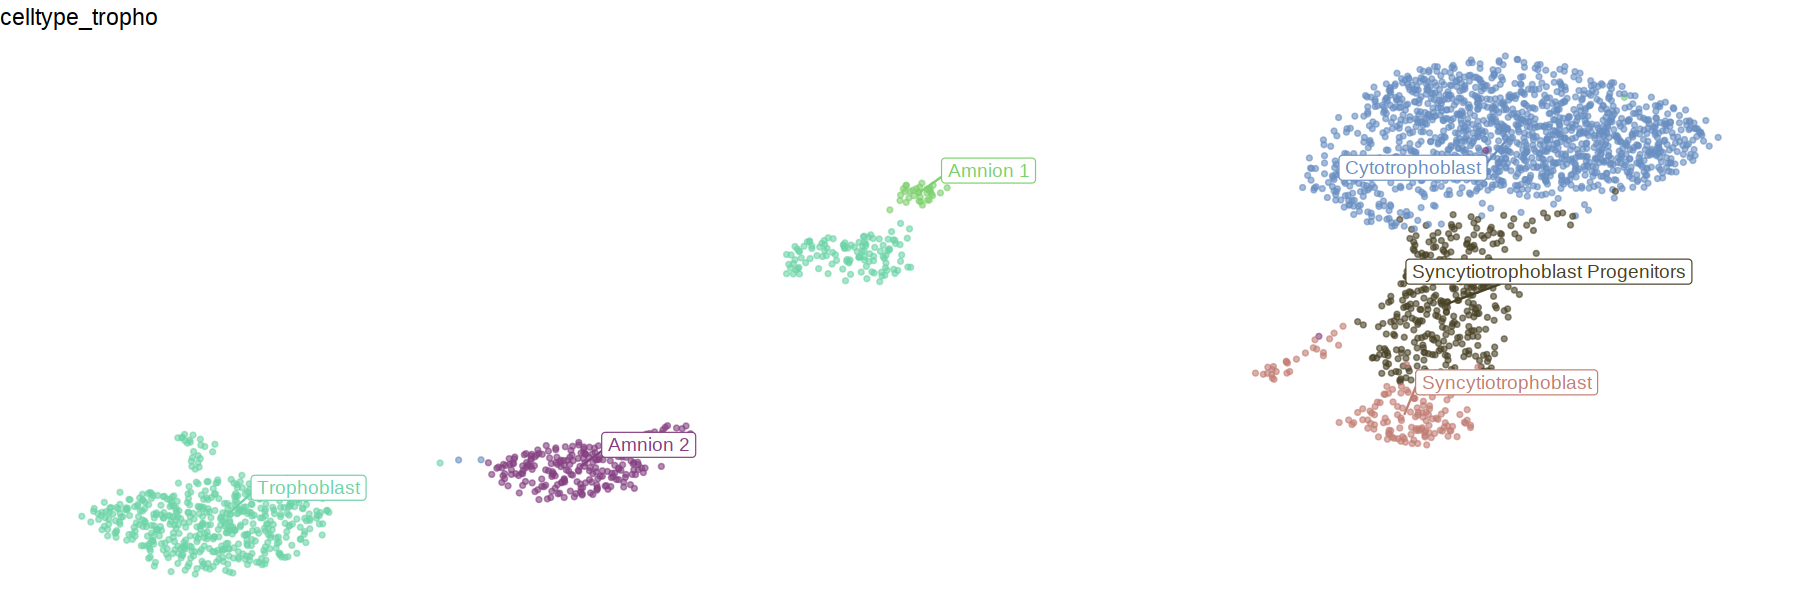

In [130]:
# Fetch UMAP coordinates
umap.dt <- getEmbedding(ArchRProject,paste0("UMAP_tropho_PeakMatrix")) %>%
  round(2) %>%
  as.data.table(keep.rownames = T) %>%
  setnames(c("cell","umap1","umap2"))

# Plot
sample_metadata = as.data.frame(getCellColData(ArchRProject))
to.plot <- umap.dt %>%
  merge(sample_metadata,by="cell")

plot = function(colors){
    # Get labels at centre of group
    labels = to.plot[,list(median(umap1), median(umap2)), 
                                  by=colors] %>%
        setnames(c('V1', 'V2'), c('umap1', 'umap2'))
    
    # Plot
    plot = ggplot(to.plot, aes_string(x="umap1", y="umap2", color=colors)) +
        geom_point(size=1, alpha=0.6) + 
        ggrepel::geom_label_repel(data=labels, 
                                    aes_string('umap1', 'umap2', label=colors, color=colors), 
                                    max.overlaps=Inf,
                                    box.padding = 0.8) + # adds text labels
        ggtitle(colors) +
        theme_void() + 
        theme(legend.position='none')
    # Add colors to umap
    if(colors=='stage'){
        plot = plot + scale_color_manual(values=opts$stage.colors)
    } else{
        plot = plot + scale_color_manual(values = as.vector(c(ArchRPalettes[[3]],ArchRPalettes[[5]], ArchRPalettes[[8]],ArchRPalettes[[9]]))[1:length(unique(to.plot[[colors]]))]) 
    }
    return(plot)
}

plot('celltype_tropho')

Warning message:
“Removed 4 row(s) containing missing values (geom_path).”


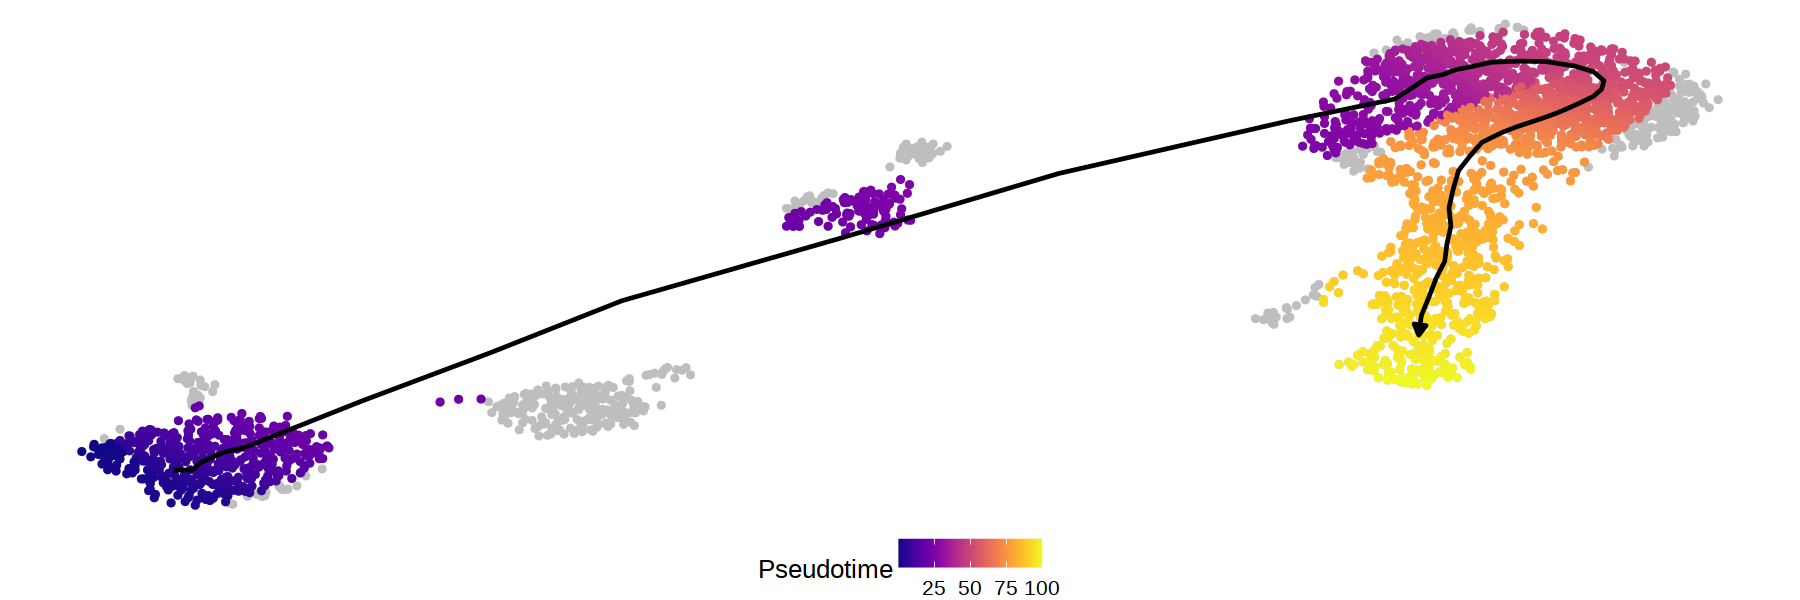

In [132]:
# Add arrow
bin = 2
k = 5

to.plot$pseudobin = cut(to.plot$Tropho, breaks=seq(0, 100, bin))
arrow = to.plot[!is.na(Tropho),list(median(umap1), median(umap2)), 
                                  by= pseudobin] %>%
        setnames(c('V1', 'V2'), c('umap1', 'umap2')) %>% .[order(pseudobin),]
# Smooth out the arrow
arrow = arrow[,c('smooth1', 'smooth2'):=list(frollmean(umap1, n = k, align = "right"),
                                      frollmean(umap2, n = k, align = "right"))]

p = ggplot(to.plot, aes(umap1, umap2)) + 
        geom_point(col='grey') + 
        geom_point(data=to.plot[!is.na(to.plot$Tropho),], aes(umap1, umap2, col=Tropho)) + 
        scale_color_viridis(option='plasma', name='Pseudotime') + 
        theme_void() + theme(text=element_text(size=15), legend.position='bottom') +
        geom_path(data=arrow, aes(smooth1,smooth2),
                  size=1, 
                  arrow = arrow(type = "closed", angle = 30, length = unit(0.1, "inches")))
p

#### Motifs over pseudotime

In [19]:
library(tidyr)


Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


The following object is masked from ‘package:S4Vectors’:

    expand




In [20]:
trajMM  <- getTrajectory(ArchRProj = ArchRProject, name = "Tropho", useMatrix = "MotifMatrix", log2Norm = FALSE)
names = sapply(strsplit(rownames(trajMM),":"), `[`, 2)
names = sapply(strsplit(names,"_"), `[`, 1)
rownames(trajMM) = names

Creating Trajectory Group Matrix..

Some values are below 0, this could be a DeviationsMatrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...



2022-05-02 14:33:25 : SuppressedMessaged due to getArchRVerbose() is FALSE!

2022-05-02 14:33:25 : SuppressedMessaged due to getArchRVerbose() is FALSE!

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



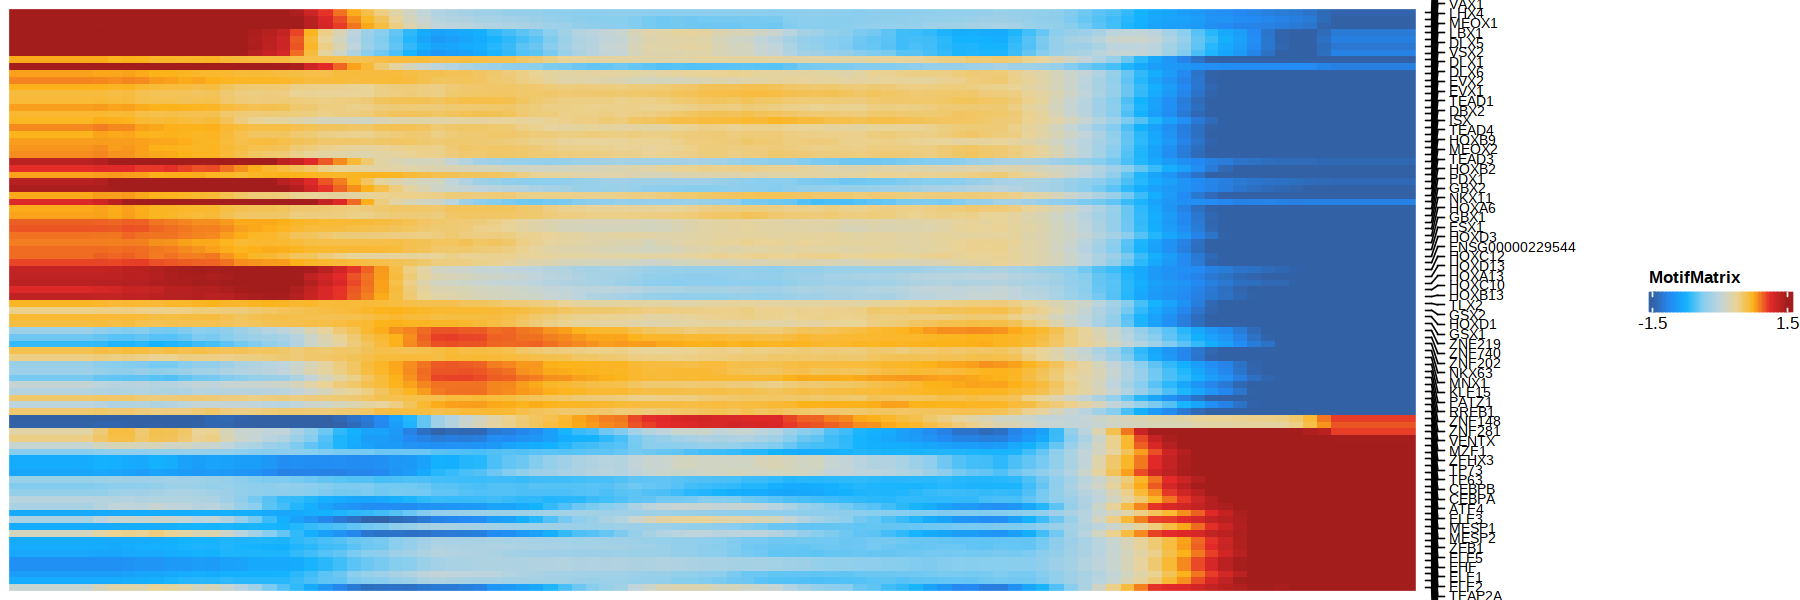

In [21]:
p1 = plotTrajectoryHeatmap(trajMM, pal = paletteContinuous(set = "solarExtra"), labelTop  = 100)
p1

In [22]:
# trajMM includes deviation and Z-score, so filter out only z-scores
TF_names = as.data.table(data.frame(rowData(trajMM), id = paste0('f',1:nrow(rowData(trajMM)))), keep.rownames=TRUE) %>% setnames('rn', 'TF')
keep = TF_names[seqnames=='z',]

In [23]:
TF_plot = c("CDX2", "TEAD4", "DLX5", "HAND1", "DLX6","PATZ1", "ZNF740",
"TP63", "GRHL1", "CEBPA","ELF3", "MITF", "TFEB","TFAP2C", "TFAP2A")

In [24]:
# exporting motif data for Dan so he can make one plot with RNA + ATAC
# Get gene score matrix
Motif = getMatrixFromProject(
  ArchRProj = ArchRProject,
  useMatrix = "MotifMatrix")

# Rename columns & rows
gene_names = sapply(strsplit(Motif@elementMetadata$name,"_"), `[`, 1)
Motif = Motif@assays@data$z
rownames(Motif) = gene_names

meta = as.data.table(ArchRProject@cellColData, keep.rownames=TRUE)[,c('rn', 'sample', 'stage', 'celltype_tropho', 'Tropho', 'Clusters')] %>%
    setnames(c('rn', 'Tropho'), c('cell', 'Pseudotime'))
head(meta)

Warning message in .local(x, row.names, optional, ...):
“Arguments in '...' ignored”


cell                             sample        stage celltype_tropho
1 rabbit_BGRGP1#AGTTACGGTACCAAGG-1 rabbit_BGRGP1 GD7   Trophoblast    
2 rabbit_BGRGP1#GCTCAGGAGATGGGAA-1 rabbit_BGRGP1 GD7   Trophoblast    
3 rabbit_BGRGP1#TCTAGTTCAAGATGCG-1 rabbit_BGRGP1 GD7   Trophoblast    
4 rabbit_BGRGP1#ACAGAAATCACTCCCA-1 rabbit_BGRGP1 GD7   Trophoblast    
5 rabbit_BGRGP1#AGCTGGCGTAAACGGC-1 rabbit_BGRGP1 GD7   Trophoblast    
6 rabbit_BGRGP1#GGAACTTGTAACCCAT-1 rabbit_BGRGP1 GD7   Trophoblast    
  Pseudotime Clusters
1 22.902796  C4      
2  8.699512  C7      
3 21.571238  C4      
4        NA  C7      
5 15.579228  C7      
6 22.769640  C4

In [81]:
# Get in long format, add meta, add zscore, smooth
plot_motif = as.data.table(as.matrix(Motif)) %>%
     .[,TF:=gene_names] %>% 
     melt(id.vars = 'TF') %>%
    .[,zscore:= scale(value), by=TF] %>% 
     setnames('variable','cell') %>% 
    merge(meta, by='cell') %>%
    .[order(Pseudotime)] %>%  
    .[, zscore_smooth:=frollmean(zscore, 10), by = TF] %>% 
    .[,zscore_capped:=ifelse(zscore>=1.5, 1.5, ifelse(zscore<=-1.5, -1.5, zscore))] %>%
    .[,zscore_smooth_capped:=ifelse(zscore_smooth>=1.5, 1.5, ifelse(zscore_smooth<=-1.5, -1.5, zscore_smooth))]

In [82]:
plot_meta = plot_motif %>% unique(by='cell') %>% .[,c('Pseudotime', 'Clusters', 'celltype_tropho')] %>% melt(id.vars='Pseudotime')

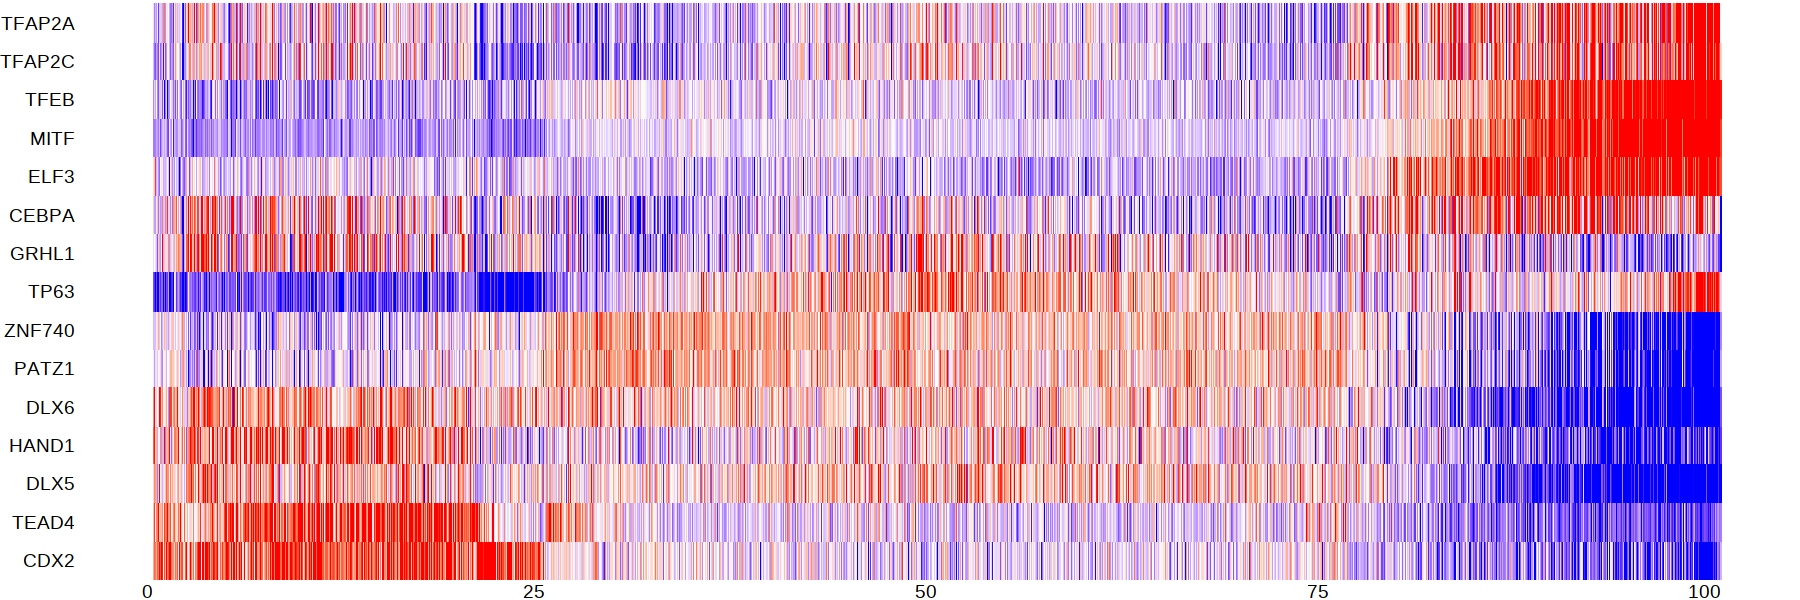

Warning message:
“Removed 1016 rows containing missing values (geom_tile).”


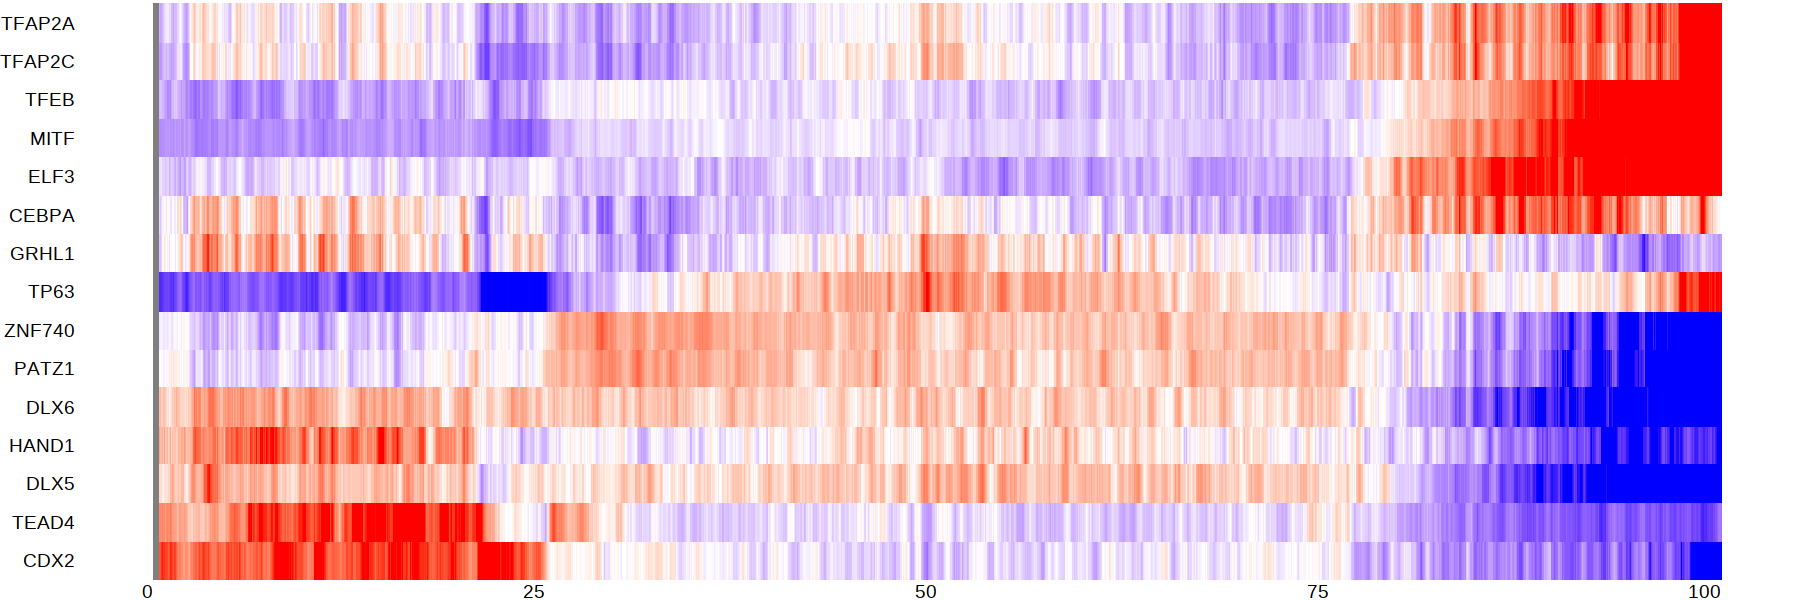

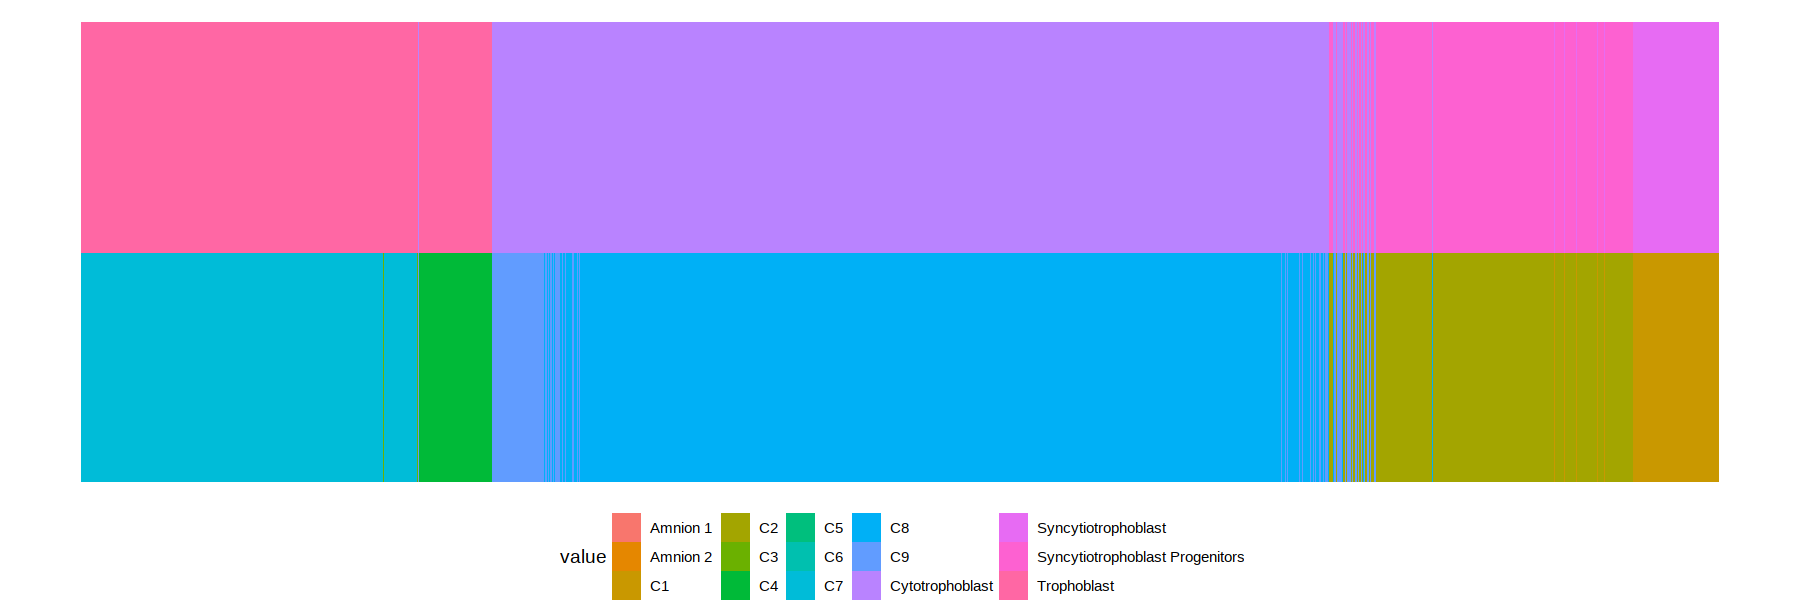

In [83]:
TF_plot = c("CDX2", "TEAD4", "DLX5", "HAND1", "DLX6","PATZ1", "ZNF740",
"TP63", "GRHL1", "CEBPA","ELF3", "MITF", "TFEB","TFAP2C", "TFAP2A")
ggplot(plot_motif[TF %in% TF_plot & !is.na(Pseudotime)], 
       aes(Pseudotime,factor(TF, levels=TF_plot), fill=zscore_capped)) + 
    geom_tile() + 
    scale_fill_gradient2(low = "blue", mid = "white", high = "red") + 
    theme_void() + 
    theme(axis.text = element_text(hjust=1), legend.position='none')
ggplot(plot_motif[TF %in% TF_plot & !is.na(Pseudotime)], 
       aes(Pseudotime,factor(TF, levels=TF_plot), fill=zscore_smooth_capped)) + 
    geom_tile() + scale_fill_gradient2(low = "blue", mid = "white", high = "red") + 
    theme_void() + 
    theme(axis.text = element_text(hjust=1), legend.position='none')
ggplot(plot_meta, 
       aes(Pseudotime,variable, fill=value)) + 
    geom_tile() + 
    theme_void() + 
    theme(axis.text = element_blank(), legend.position='bottom')

#ggplot(plot %>% filter(TF%in%TF_plot & !is.na(Pseudotime)), aes(Pseudotime,factor(TF, levels=TF_plot), fill=zscore_smooth)) + geom_tile() + scale_fill_gradient2(low = "blue", mid = "white", high = "red") + theme_void() + theme(axis.text = element_text(hjust=1), legend.position='none')

In [32]:
imputed_motif = suppressMessages(imputeMatrix(mat = as.matrix(Motif), 
                                imputeWeights = getImputeWeights(ArchRProject)))

In [108]:
# Get in long format, add meta, add zscore, smooth
plot_motif = as.data.table(imputed_motif) %>%
     .[,TF:=gene_names] %>% 
     melt(id.vars = 'TF') %>%
    .[,zscore:= scale(value), by=TF] %>% 
     setnames('variable','cell') %>% 
    merge(meta, by='cell') %>%
    .[order(Pseudotime)] %>%  
    .[, zscore_smooth:=frollmean(zscore, 10), by = TF] %>% 
    .[,zscore_capped:=ifelse(zscore>=1.5, 1.5, ifelse(zscore<=-1.5, -1.5, zscore))] %>%
    .[,zscore_smooth_capped:=ifelse(zscore_smooth>=1.5, 1.5, ifelse(zscore_smooth<=-1.5, -1.5, zscore_smooth))]

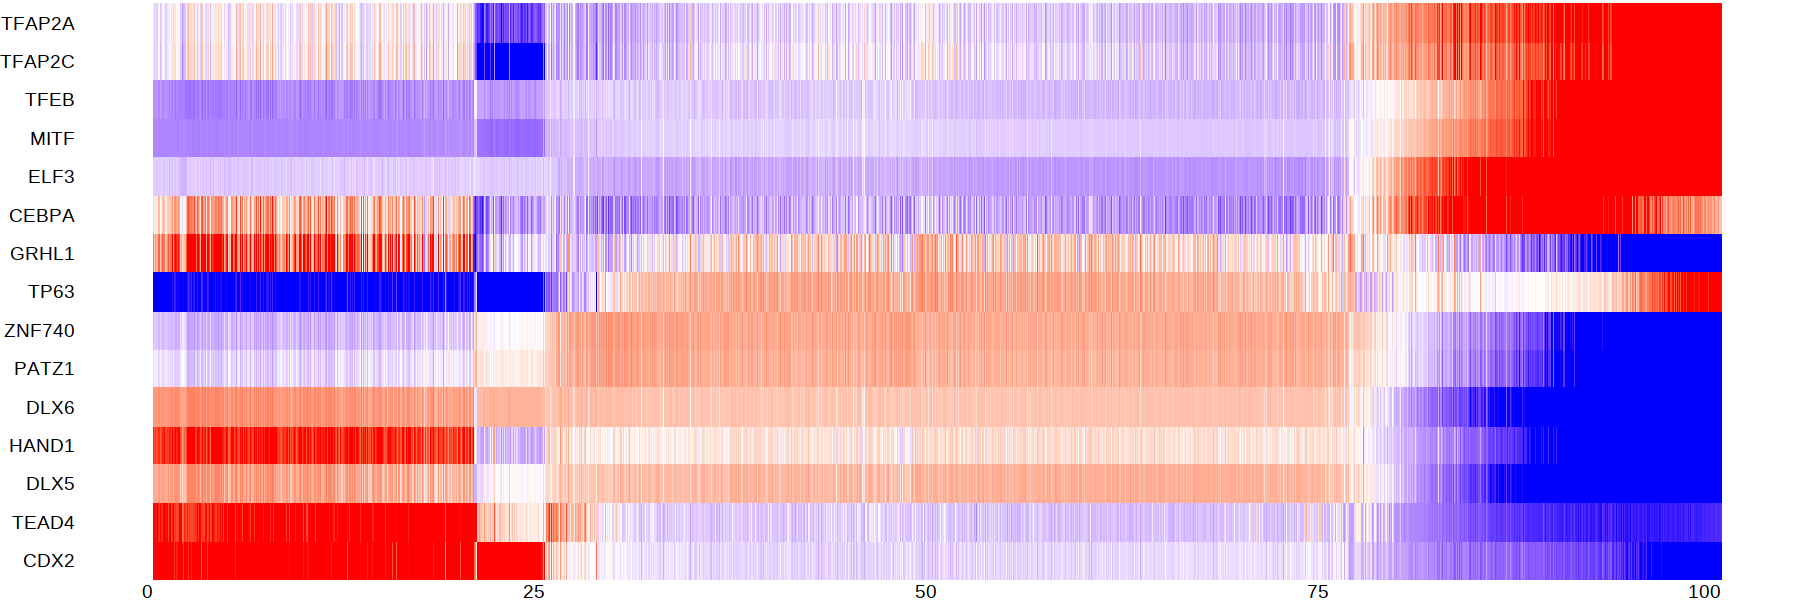

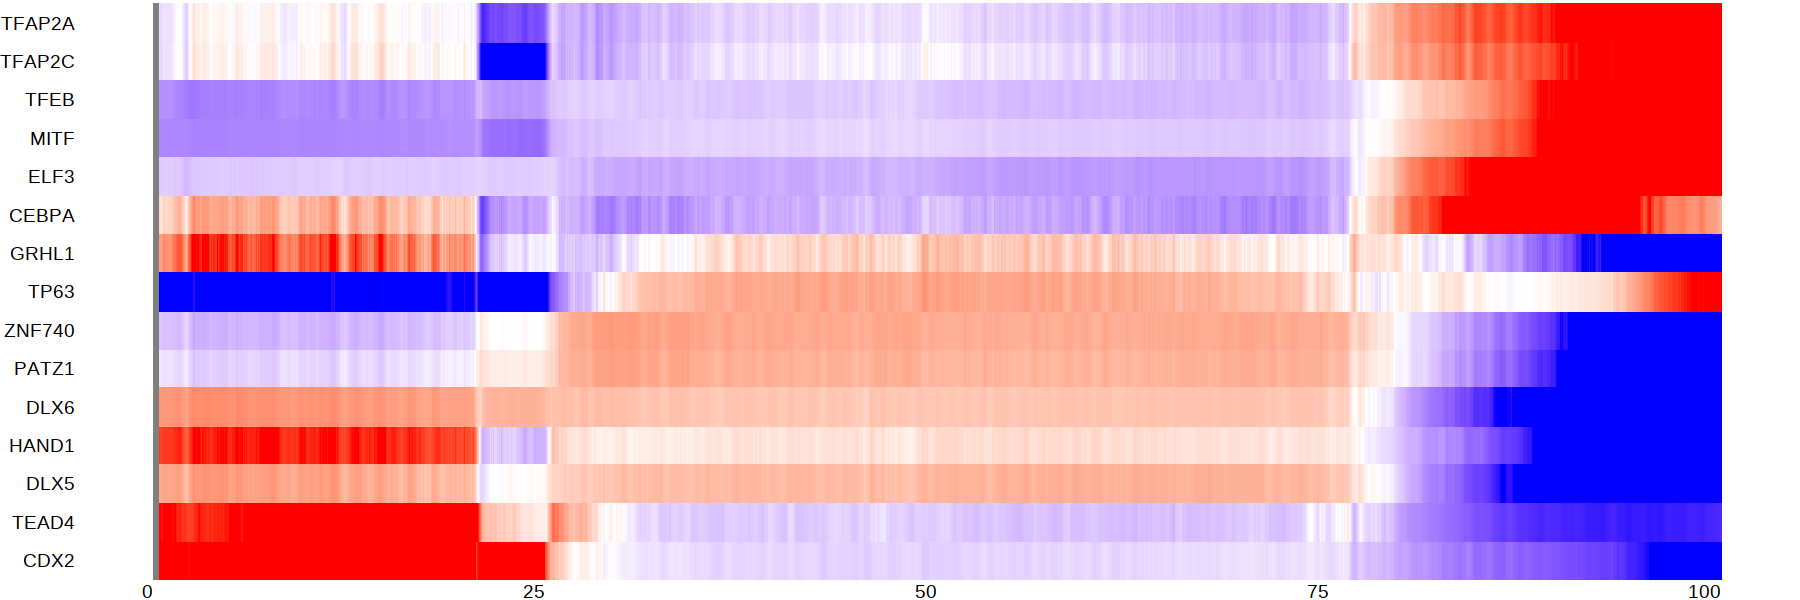

In [85]:
TF_plot = c("CDX2", "TEAD4", "DLX5", "HAND1", "DLX6","PATZ1", "ZNF740",
"TP63", "GRHL1", "CEBPA","ELF3", "MITF", "TFEB","TFAP2C", "TFAP2A")
ggplot(plot_motif[TF %in% TF_plot & !is.na(Pseudotime)], aes(Pseudotime,factor(TF, levels=TF_plot), fill=zscore_capped)) + geom_tile() + scale_fill_gradient2(low = "blue", mid = "white", high = "red") + theme_void() + theme(axis.text = element_text(hjust=1), legend.position='none')
ggplot(plot_motif[TF %in% TF_plot & !is.na(Pseudotime)], aes(Pseudotime,factor(TF, levels=TF_plot), fill=zscore_smooth_capped)) + geom_tile() + scale_fill_gradient2(low = "blue", mid = "white", high = "red") + theme_void() + theme(axis.text = element_text(hjust=1), legend.position='none')

#ggplot(plot %>% filter(TF%in%TF_plot & !is.na(Pseudotime)), aes(Pseudotime,factor(TF, levels=TF_plot), fill=zscore_smooth)) + geom_tile() + scale_fill_gradient2(low = "blue", mid = "white", high = "red") + theme_void() + theme(axis.text = element_text(hjust=1), legend.position='none')